In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM  
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.jump import JumpModel
from scipy import stats
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import wilcoxon
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import itertools



In [ ]:
def simulate_data(T, random_state=None):
    rng = np.random.default_rng(random_state)

    mu1, mu2 = 0.0006, -0.000881
    sigma1, sigma2 = 0.00757, 0.0163
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])

    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])

    states = np.zeros(T, dtype=int)
    states[0] = rng.choice([0, 1], p=stat)
    for t in range(1, T):
        states[t] = rng.choice([0, 1], p=transmat[states[t - 1]])

    y = np.zeros(T)
    for t in range(T):
        if states[t] == 0:
            y[t] = rng.normal(mu1, sigma1)
        else:
            y[t] = rng.normal(mu2, sigma2)

    return y, states

In [ ]:
def align_labels(true_labels, pred_labels):

    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(col_ind, row_ind)}
    aligned = np.array([mapping.get(x, x) for x in pred_labels])
    return aligned

In [ ]:
def calculate_bac(true_states, pred_states):

    aligned_pred = align_labels(true_states, pred_states)
    return balanced_accuracy_score(true_states, aligned_pred)

In [ ]:

def compute_per_state_accuracy(true_states, pred_states):
    aligned_pred = align_labels(true_states, pred_states)
    cm = confusion_matrix(true_states, aligned_pred, labels=[0, 1])
    denom_0 = cm[0, :].sum()
    denom_1 = cm[1, :].sum()
    acc1 = cm[0, 0] / denom_0 if denom_0 > 0 else 0
    acc2 = cm[1, 1] / denom_1 if denom_1 > 0 else 0
    bac = 0.5 * (acc1 + acc2)
    return acc1, acc2, bac


def compute_state_statistics(y, true_states, pred_states):
    aligned = align_labels(true_states, pred_states)
    stats_dict = {}
    for state in [0, 1]:
        idx = np.where(aligned == state)[0]
        if len(idx) > 0:
            stats_dict[f"state{state}_mean"] = np.mean(y[idx])
            stats_dict[f"state{state}_vol"] = np.std(y[idx])
        else:
            stats_dict[f"state{state}_mean"] = np.nan
            stats_dict[f"state{state}_vol"] = np.nan
    return stats_dict

def compute_transition_probabilities(state_seq):
    state_seq = np.array(state_seq)
    prev_states = state_seq[:-1]
    next_states = state_seq[1:]
    if np.sum(prev_states == 0) > 0:
        gamma12 = np.sum((prev_states == 0) & (next_states == 1)) / np.sum(prev_states == 0)
    else:
        gamma12 = np.nan
    if np.sum(prev_states == 1) > 0:
        gamma21 = np.sum((prev_states == 1) & (next_states == 0)) / np.sum(prev_states == 1)
    else:
        gamma21 = np.nan
    return gamma12, gamma21


def viterbi_true(y):
    T = len(y)
    mu = [0.00060, -0.000881]
    sigma = [0.00757, 0.0163]
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])
    
    delta = np.zeros((T, 2))
    psi = np.zeros((T, 2), dtype=int)
    delta[0,0] = np.log(stat[0]) + stats.norm.logpdf(y[0], loc=mu[0], scale=sigma[0])
    delta[0,1] = np.log(stat[1]) + stats.norm.logpdf(y[0], loc=mu[1], scale=sigma[1])
    psi[0, :] = 0
    for t in range(1, T):
        for j in range(2):
            temp = delta[t-1] + np.log(transmat[:, j])
            psi[t, j] = np.argmax(temp)
            delta[t, j] = np.max(temp) + stats.norm.logpdf(y[t], loc=mu[j], scale=sigma[j])
    states = np.zeros(T, dtype=int)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


In [ ]:
def run_mle(observations, n_components=2, init_type='default', seed=None):

    from hmmlearn.hmm import GaussianHMM
    
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=seed)
    
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_ = np.array([[0.9, 0.1],
                                    [0.1, 0.9]])
        model.means_ = np.array([[0.0], [0.0]])
        model.covars_ = np.array([[max(0.01, 1e-6)], 
                                  [max(0.01, 1e-6)]])
        model.init_params = ''
    
    elif init_type == 'kmeans':
        from sklearn.cluster import KMeans

        kmeans = KMeans(
            n_clusters=n_components,
            n_init=10,          
            random_state=seed   
        ).fit(observations.reshape(-1, 1))
        labels = kmeans.labels_
        
        means = []
        covars = []
        for i in range(n_components):
            obs_i = observations[labels == i]
            mu_ = np.mean(obs_i) if len(obs_i) else 0.0
            var_ = np.var(obs_i) if len(obs_i) > 0 else 0.01
            var_ = max(var_, 1e-6)
            means.append(mu_)
            covars.append(var_)
        
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_ = np.ones((n_components, n_components)) / n_components
        model.means_ = np.array(means).reshape(-1, 1)
        model.covars_ = np.array(covars).reshape(-1, 1)
        model.init_params = ''
    
    model.fit(observations.reshape(-1, 1))
    _, states_est = model.decode(observations.reshape(-1, 1))
    return model, states_est


In [ ]:
def run_jump_model(Z, n_components=2, lambda_=100.0, random_state=None):
    jm = JumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_iter=10,
        random_state=random_state
    )
    jm.fit(Z)
    return jm.labels_

In [ ]:
def run_sparse_jump_model(Z, n_components=2, lambda_=10.0, max_feats=10, random_state=None):
    sjm = SparseJumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_feats=max_feats,
        max_iter=10,
        random_state=random_state
    )
    sjm.fit(Z)
    return sjm.labels_

In [ ]:
def compute_temporal_features(y, l):
    T = len(y)
    feats = np.zeros((T, 9), dtype=float)
    half = (l - 1) // 2
    for t in range(T):
        feats[t, 0] = y[t]
        feats[t, 1] = abs(y[t] - y[t-1]) if t > 0 else 0.
        feats[t, 2] = abs(y[t+1] - y[t]) if t < (T-1) else 0.
        left_c = max(0, t - half)
        right_c = min(T, t + half + 1)
        window_c = y[left_c:right_c]
        feats[t, 3] = np.mean(window_c)
        feats[t, 4] = np.std(window_c)
        left_l = max(0, t - l)
        right_l = t
        window_l = y[left_l:right_l]
        feats[t, 5] = np.mean(window_l) if len(window_l) > 0 else 0.
        feats[t, 6] = np.std(window_l) if len(window_l) > 0 else 0.
        left_r = t
        right_r = min(T, t + l)
        window_r = y[left_r:right_r]
        feats[t, 7] = np.mean(window_r) if len(window_r) > 0 else 0.
        feats[t, 8] = np.std(window_r) if len(window_r) > 0 else 0.
    return feats


def combine_features(y, l_list=[5, 13]):
    feat_list = []
    for l in l_list:
        feat_list.append(compute_temporal_features(y, l))
    return np.hstack(feat_list)

In [ ]:
def run_one_simulation(seed, T=250, lambda_jump=30.0, lambda_sjump=32.0, max_feats=1):
    y, true_states = simulate_data(T, random_state=seed)

    pred_true = viterbi_true(y)  
    acc1_true, acc2_true, bac_true = compute_per_state_accuracy(true_states, pred_true)
    state_stats_true = compute_state_statistics(y, true_states, pred_true)

    Z = combine_features(y, l_list=[5, 13])
    Z_df = pd.DataFrame(Z)
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()
    Z_clipped = clipper.fit_transform(Z_df)
    Z_scaled = scaler.fit_transform(Z_clipped)
    Z_scaled_arr = Z_scaled.values

    model_mle, states_est_mle = run_mle(y, n_components=2, init_type='default')
    acc1_mle, acc2_mle, bac_mle = compute_per_state_accuracy(true_states, states_est_mle)
    state_stats_mle = compute_state_statistics(y, true_states, states_est_mle)
    mu1_mle = float(model_mle.means_[0, 0])
    mu2_mle = float(model_mle.means_[1, 0])
    sigma1_mle = float(np.sqrt(model_mle.covars_[0, 0]))
    sigma2_mle = float(np.sqrt(model_mle.covars_[1, 0]))
    gamma12_mle = float(model_mle.transmat_[0, 1])
    gamma21_mle = float(model_mle.transmat_[1, 0])

    model_mle_k, states_est_mle_k = run_mle(y, n_components=2, init_type='kmeans')
    acc1_mlek, acc2_mlek, bac_mlek = compute_per_state_accuracy(true_states, states_est_mle_k)
    state_stats_mlek = compute_state_statistics(y, true_states, states_est_mle_k)
    mu1_mlek = float(model_mle_k.means_[0, 0])
    mu2_mlek = float(model_mle_k.means_[1, 0])
    sigma1_mlek = float(np.sqrt(model_mle_k.covars_[0, 0]))
    sigma2_mlek = float(np.sqrt(model_mle_k.covars_[1, 0]))
    gamma12_mlek = float(model_mle_k.transmat_[0, 1])
    gamma21_mlek = float(model_mle_k.transmat_[1, 0])

    pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_jump, random_state=seed)
    acc1_jump, acc2_jump, bac_jump = compute_per_state_accuracy(true_states, pred_jump)
    state_stats_jump = compute_state_statistics(y, true_states, pred_jump)
    gamma12_jump, gamma21_jump = compute_transition_probabilities(pred_jump)  

    pred_sjump = run_sparse_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_sjump,
                                       max_feats=max_feats, random_state=seed)
    acc1_sjump, acc2_sjump, bac_sjump = compute_per_state_accuracy(true_states, pred_sjump)
    state_stats_sjump = compute_state_statistics(y, true_states, pred_sjump)
    gamma12_sjump, gamma21_sjump = compute_transition_probabilities(pred_sjump)  

    return {
        "seed": seed,
        "T": T,
        "True_state0_mean": state_stats_true["state0_mean"],
        "True_state0_vol": state_stats_true["state0_vol"],
        "True_state1_mean": state_stats_true["state1_mean"],
        "True_state1_vol": state_stats_true["state1_vol"],
        "True_acc1": acc1_true,
        "True_acc2": acc2_true,
        "True_BAC": bac_true,
        "MLE_mu1": mu1_mle, "MLE_mu2": mu2_mle,
        "MLE_sigma1": sigma1_mle, "MLE_sigma2": sigma2_mle,
        "MLE_gamma12": gamma12_mle, "MLE_gamma21": gamma21_mle,
        "MLE_acc1": acc1_mle, "MLE_acc2": acc2_mle, "MLE_BAC": bac_mle,
        "MLE_state0_mean": state_stats_mle["state0_mean"],
        "MLE_state0_vol": state_stats_mle["state0_vol"],
        "MLE_state1_mean": state_stats_mle["state1_mean"],
        "MLE_state1_vol": state_stats_mle["state1_vol"],
        "MLEK_mu1": mu1_mlek, "MLEK_mu2": mu2_mlek,
        "MLEK_sigma1": sigma1_mlek, "MLEK_sigma2": sigma2_mlek,
        "MLEK_gamma12": gamma12_mlek, "MLEK_gamma21": gamma21_mlek,
        "MLEK_acc1": acc1_mlek, "MLEK_acc2": acc2_mlek, "MLEK_BAC": bac_mlek,
        "MLEK_state0_mean": state_stats_mlek["state0_mean"],
        "MLEK_state0_vol": state_stats_mlek["state0_vol"],
        "MLEK_state1_mean": state_stats_mlek["state1_mean"],
        "MLEK_state1_vol": state_stats_mlek["state1_vol"],
        "Jump_acc1": acc1_jump, "Jump_acc2": acc2_jump, "Jump_BAC": bac_jump,
        "Jump_state0_mean": state_stats_jump["state0_mean"],
        "Jump_state0_vol": state_stats_jump["state0_vol"],
        "Jump_state1_mean": state_stats_jump["state1_mean"],
        "Jump_state1_vol": state_stats_jump["state1_vol"],
        "Jump_gamma12": gamma12_jump, "Jump_gamma21": gamma21_jump,  
        "SparseJump_acc1": acc1_sjump, "SparseJump_acc2": acc2_sjump, "SparseJump_BAC": bac_sjump,
        "SparseJump_state0_mean": state_stats_sjump["state0_mean"],
        "SparseJump_state0_vol": state_stats_sjump["state0_vol"],
        "SparseJump_state1_mean": state_stats_sjump["state1_mean"],
        "SparseJump_state1_vol": state_stats_sjump["state1_vol"],
        "SparseJump_gamma12": gamma12_sjump, "SparseJump_gamma21": gamma21_sjump  
    }

In [ ]:
if __name__ == "__main__":
    T_values = [250, 500, 1000, 2000]
    n_simulations = 1000

    lambda_jump = 90.0
    lambda_sjump = 90.0
    max_feats = 9

    num_cores = multiprocessing.cpu_count()
    print(f"Running {n_simulations} simulations per T value on {num_cores} cores...")

    all_results = []
    for T in T_values:
        print(f"\nRunning simulations for T = {T}...")
        seeds = np.arange(n_simulations)
        results_list = Parallel(n_jobs=num_cores)(
            delayed(run_one_simulation)(
                seed=s,
                T=T,
                lambda_jump=lambda_jump,
                lambda_sjump=lambda_sjump,
                max_feats=max_feats
            ) for s in seeds
        )
        df_results_T = pd.DataFrame(results_list)
        all_results.append(df_results_T)

    final_results = pd.concat(all_results, ignore_index=True)

    for T in T_values:
        df_T = final_results[final_results["T"] == T]
        print(f"\n=== Results Summary for T = {T} ===")
        for param in ["MLE_mu1", "MLE_mu2", "MLE_sigma1", "MLE_sigma2", "MLE_gamma12", "MLE_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        for stat in ["MLE_state0_mean", "MLE_state0_vol", "MLE_state1_mean", "MLE_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        for param in ["MLEK_mu1", "MLEK_mu2", "MLEK_sigma1", "MLEK_sigma2", "MLEK_gamma12", "MLEK_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        for stat in ["MLEK_state0_mean", "MLEK_state0_vol", "MLEK_state1_mean", "MLEK_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        print(f"MLE default BAC: {df_T['MLE_BAC'].mean():.3f} ± {df_T['MLE_BAC'].std():.3f}")
        print(f"MLE k-means BAC: {df_T['MLEK_BAC'].mean():.3f} ± {df_T['MLEK_BAC'].std():.3f}")
        print(f"Jump Model BAC : {df_T['Jump_BAC'].mean():.3f} ± {df_T['Jump_BAC'].std():.3f}")
        print(f"Sparse Jump BAC: {df_T['SparseJump_BAC'].mean():.3f} ± {df_T['SparseJump_BAC'].std():.3f}")

    print("\nSample of raw results (first 10 rows):")
    print(final_results.head(10))

Running 1000 simulations per T value on 16 cores...

Running simulations for T = 250...

Running simulations for T = 500...

Running simulations for T = 1000...

Running simulations for T = 2000...

=== Results Summary for T = 250 ===
MLE_mu1: 0.0004 ± 0.0029
MLE_mu2: -0.0003 ± 0.0066
MLE_sigma1: 0.0135 ± 0.0124
MLE_sigma2: 18.0530 ± 15.6314
MLE_gamma12: 0.0363 ± 0.1304
MLE_gamma21: 0.6850 ± 0.4050
MLE_state0_mean: 0.0006 ± 0.0028
MLE_state0_vol: 0.0082 ± 0.0018
MLE_state1_mean: -0.0023 ± 0.0197
MLE_state1_vol: 0.0179 ± 0.0112
MLEK_mu1: 0.0003 ± 0.0039
MLEK_mu2: 0.0003 ± 0.0043
MLEK_sigma1: 0.0770 ± 1.4129
MLEK_sigma2: 0.2989 ± 2.9866
MLEK_gamma12: 0.4710 ± 0.1633
MLEK_gamma21: 0.5009 ± 0.1626
MLEK_state0_mean: 0.0005 ± 0.0051
MLEK_state0_vol: 0.0066 ± 0.0023
MLEK_state1_mean: -0.0009 ± 0.0144
MLEK_state1_vol: 0.0067 ± 0.0073
MLE default BAC: 0.531 ± 0.085
MLE k-means BAC: 0.460 ± 0.121
Jump Model BAC : 0.655 ± 0.267
Sparse Jump BAC: 0.659 ± 0.272

=== Results Summary for T = 500 ===
M

In [ ]:
import numpy as np

T_values = [250, 500, 1000, 2000]
n_sims = 1000  

true_acc_by_T = {}
for T in T_values:
    acc0_list, acc1_list, bac_list = [], [], []
    for seed in range(n_sims):
        y, true_states = simulate_data(T, random_state=seed)
        pred = viterbi_true(y)  
        a0, a1, b = compute_per_state_accuracy(true_states, pred)
        acc0_list.append(a0)
        acc1_list.append(a1)
        bac_list.append(b)
    
    true_acc_by_T[T] = {
        "acc0": np.mean(acc0_list),
        "acc1": np.mean(acc1_list),
        "BAC":  np.mean(bac_list)
    }

for T in T_values:
    print(f"T={T} --> True acc0={true_acc_by_T[T]['acc0']:.4f}, "
          f"acc1={true_acc_by_T[T]['acc1']:.4f}, "
          f"BAC={true_acc_by_T[T]['BAC']:.4f}")

In [ ]:
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

true_acc_by_T = {
    250: {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500: {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

In [ ]:
T_values = final_results["T"].unique()

for T_val in sorted(T_values):
    df_T = final_results[final_results["T"] == T_val]
    
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            "acc1":        true_acc_by_T[T_val]["acc0"],  
            "acc2":        true_acc_by_T[T_val]["acc1"],
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12":     df_T["MLE_gamma12"].mean(),
            "gamma21":     df_T["MLE_gamma21"].mean(),
            "acc1":        df_T["MLE_acc1"].mean(),
            "acc2":        df_T["MLE_acc2"].mean(),
            "BAC":         df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12":     df_T["MLEK_gamma12"].mean(),
            "gamma21":     df_T["MLEK_gamma21"].mean(),
            "acc1":        df_T["MLEK_acc1"].mean(),
            "acc2":        df_T["MLEK_acc2"].mean(),
            "BAC":         df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12":     df_T["Jump_gamma12"].mean(),
            "gamma21":     df_T["Jump_gamma21"].mean(),
            "acc1":        df_T["Jump_acc1"].mean(),
            "acc2":        df_T["Jump_acc2"].mean(),
            "BAC":         df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12":     df_T["SparseJump_gamma12"].mean(),
            "gamma21":     df_T["SparseJump_gamma21"].mean(),
            "acc1":        df_T["SparseJump_acc1"].mean(),
            "acc2":        df_T["SparseJump_acc2"].mean(),
            "BAC":         df_T["SparseJump_BAC"].mean()
        }
    }
    
    summary_df = pd.DataFrame(summary_dict).T
    
    col_order = [
        "state0_mean", "state1_mean",
        "state0_vol",  "state1_vol",
        "gamma12",     "gamma21",
        "acc1",        "acc2", 
        "BAC"
    ]
    summary_df = summary_df[col_order]

    print(f"\nSummary for T = {T_val}")
    print(summary_df)

In [ ]:
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

true_acc_by_T = {
    250:  {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500:  {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

final_result_errors["True_state0_mean"] = TRUE_MU0
final_result_errors["True_state1_mean"] = TRUE_MU1
final_result_errors["True_state0_vol"]  = TRUE_SIGMA0
final_result_errors["True_state1_vol"]  = TRUE_SIGMA1
final_result_errors["True_gamma12"]     = TRUE_GAMMA12
final_result_errors["True_gamma21"]     = TRUE_GAMMA21

for idx, row in final_result_errors.iterrows():
    tval = row["T"]
    true_accs = true_acc_by_T[tval]  
    final_result_errors.at[idx, "True_acc1"] = true_accs["acc0"]  
    final_result_errors.at[idx, "True_acc2"] = true_accs["acc1"]
    final_result_errors.at[idx, "True_BAC"]  = true_accs["BAC"]


metric_list = [
    "state0_mean", "state1_mean",
    "state0_vol",  "state1_vol",
    "gamma12",     "gamma21",
    "acc1",        "acc2",
    "BAC"
]
model_prefixes = ["MLE", "MLEK", "Jump", "SparseJump"]

for metric in metric_list:
    true_col = f"True_{metric}"
    for prefix in model_prefixes:
        est_col = f"{prefix}_{metric}"
        err_col = f"{prefix}_{metric}_error"
        final_result_errors[err_col] = (
            final_result_errors[est_col] 
            - final_result_errors[true_col]
        ).abs()

final_result_errors.to_csv("g_final_result_errors.csv", index=False)


In [ ]:
def two_sided_wilcoxon_p(diffs, atol=1e-10):
    diffs = np.array(diffs)
    diffs = diffs[~np.isnan(diffs)]  
    
    if len(diffs) == 0:
        return 1.0
    if np.allclose(diffs, 0, atol=atol):
        return 1.0
    

    try:
        _, p = wilcoxon(diffs)
        return p
    except ValueError:
        return np.nan

def one_sided_pval(diffs, p_two_sided):
    if np.isnan(p_two_sided):
        return np.nan
    
    mean_diff = np.mean(diffs)
    if mean_diff > 0:
        return p_two_sided / 2
    else:
        return 1 - p_two_sided / 2


T_values = [250, 500, 1000, 2000]
for T_val in T_values:
    df_T = final_result_errors[final_result_errors["T"] == T_val]
    table_rows = []
    for metric in metric_list:
        e_mle    = df_T[f"MLE_{metric}_error"]
        e_mlek   = df_T[f"MLEK_{metric}_error"]
        e_jump   = df_T[f"Jump_{metric}_error"]
        e_sparse = df_T[f"SparseJump_{metric}_error"]

        mean_mle    = e_mle.mean()
        mean_mlek   = e_mlek.mean()
        mean_jump   = e_jump.mean()
        mean_sparse = e_sparse.mean()

        diff_mle = e_mle - e_sparse
        p2_mle  = two_sided_wilcoxon_p(diff_mle)
        p1_mle  = one_sided_pval(diff_mle, p2_mle)

        diff_mlek = e_mlek - e_sparse
        p2_mlek  = two_sided_wilcoxon_p(diff_mlek)
        p1_mlek  = one_sided_pval(diff_mlek, p2_mlek)

        diff_jump = e_jump - e_sparse
        p2_jump  = two_sided_wilcoxon_p(diff_jump)
        p1_jump  = one_sided_pval(diff_jump, p2_jump)

        table_rows.append({
            "Parameter": metric,
            "MLE Mean Error": mean_mle,
            "MLEK Mean Error": mean_mlek,
            "Jump Mean Error": mean_jump,
            "SparseJump Mean Error": mean_sparse,
            "p (Sparse < MLE)": p1_mle,
            "p (Sparse < MLEK)": p1_mlek,
            "p (Sparse < Jump)": p1_jump,
        })
        
    wilcoxon_table_T = pd.DataFrame(table_rows)
    print(f"\n=== One-Sided Wilcoxon Results for T = {T_val} ===")
    print(wilcoxon_table_T.to_string(index=False, float_format="%.4f"))

    

In [ ]:
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

true_acc_by_T = {
    250: {"acc1": 0.9945, "acc2": 0.3959, "BAC": 0.6952},
    500: {"acc1": 0.9959, "acc2": 0.5635, "BAC": 0.7797},
    1000: {"acc1": 0.9963, "acc2": 0.7577, "BAC": 0.8770},
    2000: {"acc1": 0.9962, "acc2": 0.8616, "BAC": 0.9289},
}

methods = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]
T_values = sorted(final_results["T"].unique())
rows = []

for T_val in T_values:
    df_T = final_results[final_results["T"] == T_val]
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            "acc1":        true_acc_by_T[T_val]["acc1"],
            "acc2":        true_acc_by_T[T_val]["acc2"],
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12": df_T["MLE_gamma12"].mean(),
            "gamma21": df_T["MLE_gamma21"].mean(),
            "acc1": df_T["MLE_acc1"].mean(),
            "acc2": df_T["MLE_acc2"].mean(),
            "BAC": df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12": df_T["MLEK_gamma12"].mean(),
            "gamma21": df_T["MLEK_gamma21"].mean(),
            "acc1": df_T["MLEK_acc1"].mean(),
            "acc2": df_T["MLEK_acc2"].mean(),
            "BAC": df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12": df_T["Jump_gamma12"].mean(),
            "gamma21": df_T["Jump_gamma21"].mean(),
            "acc1": df_T["Jump_acc1"].mean(),
            "acc2": df_T["Jump_acc2"].mean(),
            "BAC": df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12": df_T["SparseJump_gamma12"].mean(),
            "gamma21": df_T["SparseJump_gamma21"].mean(),
            "acc1": df_T["SparseJump_acc1"].mean(),
            "acc2": df_T["SparseJump_acc2"].mean(),
            "BAC": df_T["SparseJump_BAC"].mean()
        }
    }
    
    for method_name, metrics in summary_dict.items():
        row = {"T": T_val, "Method": method_name}
        row.update(metrics)
        rows.append(row)

df_summary = pd.DataFrame(rows).round(7)

method_styles = {
    "True":         {"linestyle": "--", "marker": None, "color": "black"},
    "MLE default":  {"linestyle": "-",  "marker": "o",  "color": "blue"},
    "MLE k-means":  {"linestyle": "-",  "marker": "o",  "color": "green"},
    "Jump Model":   {"linestyle": "-",  "marker": "^",  "color": "orange"},
    "Sparse Jump":  {"linestyle": "-",  "marker": "^",  "color": "red"}
}

param_list = [
    ("state0_mean", "Mean State 0"),
    ("state1_mean", "Mean State 1"),
    ("state0_vol",  "Volatility State 0"),
    ("state1_vol",  "Volatility State 1"),
    ("gamma12",     "Transition 0→1"),
    ("gamma21",     "Transition 1→0"),
    ("acc1",        "Accuracy State 0"),
    ("acc2",        "Accuracy State 1"),
    ("BAC",         "Balanced Accuracy")
]

fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
axs = axs.ravel()

for i, (col, title) in enumerate(param_list):
    ax = axs[i]
    for method in methods:
        sub_df = df_summary[df_summary["Method"] == method]
        y_vals = []
        for tval in T_values:
            row = sub_df[sub_df["T"] == tval]
            if len(row) == 1:
                y_vals.append(row[col].values[0])
            else:
                y_vals.append(np.nan)
        style = method_styles[method]
        ax.plot(T_values, y_vals,
                linestyle=style["linestyle"],
                marker=style["marker"],
                color=style["color"],
                label=method)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Simulation Length (T)")
    ax.grid(False)

axs[-1].legend(loc="best", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:

def simulate_for_lambda(T_val, lam, n_simulations):
    bac_list = []
    for seed in range(n_simulations):
        y, true_states = simulate_data(T_val, random_state=seed)
        
        Z = combine_features(y, l_list=[5, 13])
        Z_df = pd.DataFrame(Z)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        Z_clipped = clipper.fit_transform(Z_df)
        Z_scaled = scaler.fit_transform(Z_clipped)
        Z_scaled_arr = Z_scaled.values

        pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lam, random_state=seed)

        _, _, bac_val = compute_per_state_accuracy(true_states, pred_jump)
        bac_list.append(bac_val)
        
    mean_bac = np.mean(bac_list)
    return {"T": T_val, "lambda": lam, "BAC": mean_bac}

lambda_grid = np.logspace(-2, 2.5, 10)  
T_values_lam = [250, 500, 1000, 2000]
n_simulations_lam = 30

results_lam = Parallel(n_jobs=-1)(
    delayed(simulate_for_lambda)(T_val, lam, n_simulations_lam)
    for T_val in T_values_lam
    for lam in lambda_grid
)

df_lambda = pd.DataFrame(results_lam)


In [ ]:
plt.figure(figsize=(8, 6))
for T_val in T_values_lam:
    sub_df = df_lambda[df_lambda["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Jump Model)")
plt.title("BAC vs. Penalty Parameter (Jump Model)")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
for T_val in T_values_sjump:
    sub_df = df_sjump[df_sjump["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Sparse Jump)")
plt.title("BAC vs. Penalty Parameter (SparseJumpModel, max_feats=15)")
plt.legend()
plt.show()

In [34]:
import os
print("cwd:", os.getcwd())
print(os.listdir())


cwd: c:\git\thesis_vri_vp\Vlad\Distribution_Simulation_\20250412_dist_sim_vff\20250412_Dist_sim_gaussian_VFf
['20250303_Dist_Sim_Gaussian_(n=1000)_Vf3.0 - Copy - Copy.ipynb', '20250303_Dist_Sim_Gaussian_(n=1000)_Vf3.0 - Copy.ipynb', 'Dist simulation fitted - Copy.docx', 'Dist simulation fitted.docx', 'gdf_lambda.csv', 'gdf_sjump.csv', 'gdf_summary.csv', 'gfinal_results.csv', 'gwilcoxon_table_T.csv', 'g_final_result_errors.csv']


In [ ]:
import pandas as pd

final_results = pd.read_csv("gfinal_results.csv")

TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

true_acc_by_T = {
    250:  {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500:  {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

all_summaries = []
for T_val in sorted(true_acc_by_T.keys()):
    df_T = final_results[final_results["T"] == T_val]
    
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            "acc1":        true_acc_by_T[T_val]["acc0"],  
            "acc2":        true_acc_by_T[T_val]["acc1"],  
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12":     df_T["MLE_gamma12"].mean(),
            "gamma21":     df_T["MLE_gamma21"].mean(),
            "acc1":        df_T["MLE_acc1"].mean(),
            "acc2":        df_T["MLE_acc2"].mean(),
            "BAC":         df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12":     df_T["MLEK_gamma12"].mean(),
            "gamma21":     df_T["MLEK_gamma21"].mean(),
            "acc1":        df_T["MLEK_acc1"].mean(),
            "acc2":        df_T["MLEK_acc2"].mean(),
            "BAC":         df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12":     df_T["Jump_gamma12"].mean(),
            "gamma21":     df_T["Jump_gamma21"].mean(),
            "acc1":        df_T["Jump_acc1"].mean(),
            "acc2":        df_T["Jump_acc2"].mean(),
            "BAC":         df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12":     df_T["SparseJump_gamma12"].mean(),
            "gamma21":     df_T["SparseJump_gamma21"].mean(),
            "acc1":        df_T["SparseJump_acc1"].mean(),
            "acc2":        df_T["SparseJump_acc2"].mean(),
            "BAC":         df_T["SparseJump_BAC"].mean()
        },
    }
    
    summary_df = pd.DataFrame(summary_dict).T.reset_index().rename(columns={"index":"Method"})
    summary_df["T"] = T_val
    summary_df = summary_df[
        ["T","Method",
         "state0_mean","state1_mean",
         "state0_vol","state1_vol",
         "gamma12","gamma21",
         "acc1","acc2","BAC"]
    ]
    
    all_summaries.append(summary_df)

df_summary = pd.concat(all_summaries, ignore_index=True)

print(df_summary.head())


     T       Method  state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
0  250         True     0.000600    -0.000881    0.007570    0.016300  0.002400  0.023200  0.994500  0.395900  0.695200
1  250  MLE default     0.000551    -0.002316    0.008248    0.017855  0.036333  0.684956  0.970924  0.090198  0.530561
2  250  MLE k-means     0.000492    -0.000879    0.006616    0.006675  0.470951  0.500916  0.751431  0.169236  0.460333
3  250   Jump Model     0.000604    -0.000120    0.007556    0.011547  0.003225  0.021976  0.888352  0.421323  0.654838
4  250  Sparse Jump     0.000600    -0.000069    0.007526    0.011529  0.003476  0.021705  0.886006  0.431403  0.658705


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

def plot_parameter(
    df, 
    param_col,
    param_label,
    log_y=False,
    methods=("True", "MLE", "MLE_k", "Jump", "Sparse Jump"),
    scale_factor=1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=None  
):

    plt.figure(figsize=figsize)
    
    method_styles = {
        "True":         {"color": "black", "linestyle": ":",  "marker": None, "linewidth": 1.5},
        "MLE default":  {"color": "blue",  "linestyle": "-",   "marker": "o",  "linewidth": 1.5},
        "MLE k-means":  {"color": "green", "linestyle": "-",   "marker": "s",  "linewidth": 1.5},
        "Jump Model":   {"color": "orange","linestyle": "-",   "marker": "^",  "linewidth": 1.5},
        "Sparse Jump":  {"color": "red",   "linestyle": "-",   "marker": "d",  "linewidth": 1.5}
    }
    
    T_values = sorted(df["T"].unique())
    
    all_scaled = []
    
    for method in methods:
        sub_df = df[df["Method"] == method].copy()
        sub_df.sort_values(by="T", inplace=True)
        
        xvals, yvals = [], []
        for t in T_values:
            row = sub_df[sub_df["T"] == t]
            xvals.append(t)
            raw_val = row[param_col].iloc[0] if len(row) == 1 else np.nan
            scaled_val = raw_val * scale_factor if not pd.isna(raw_val) else np.nan
            yvals.append(scaled_val)
        all_scaled.extend([val for val in yvals if not pd.isna(val)])
        
        style = method_styles.get(method, {"color": "black", "linestyle": "-", "marker": "o", "linewidth": 1.5})
        
        label = legend_labels.get(method, method) if legend_labels is not None else method
        
        plt.plot(
            xvals, 
            yvals, 
            label=label, 
            color=style["color"],
            linestyle=style["linestyle"],
            marker=style["marker"],
            linewidth=style["linewidth"],
            markersize=4 if style["marker"] is not None else None
        )
    
    plt.xticks([250, 500, 1000, 2000])
    plt.xlabel(r"Simulation length $T$")
    
    if scale_factor != 1:
        exponent = int(np.log10(scale_factor))
        factor_label = r"$\,\times\,10^{-" + f"{abs(exponent)}" + "}$"
    else:
        factor_label = ""
    plt.ylabel(param_label + factor_label)
    
    if log_y:
        plt.yscale('log')
    
    if preset_y_limits is not None:
        plt.ylim(preset_y_limits)
    elif all_scaled:
        y_min, y_max = min(all_scaled), max(all_scaled)
        margin = 0.1 * (y_max - y_min) if (y_max - y_min) != 0 else 1e-6
        plt.ylim(y_min - margin, y_max + margin)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vri\AppData\Local\Temp\ipykernel_13704\3822704046.py:29: SyntaxWarning: invalid escape sequence '\m'
  """


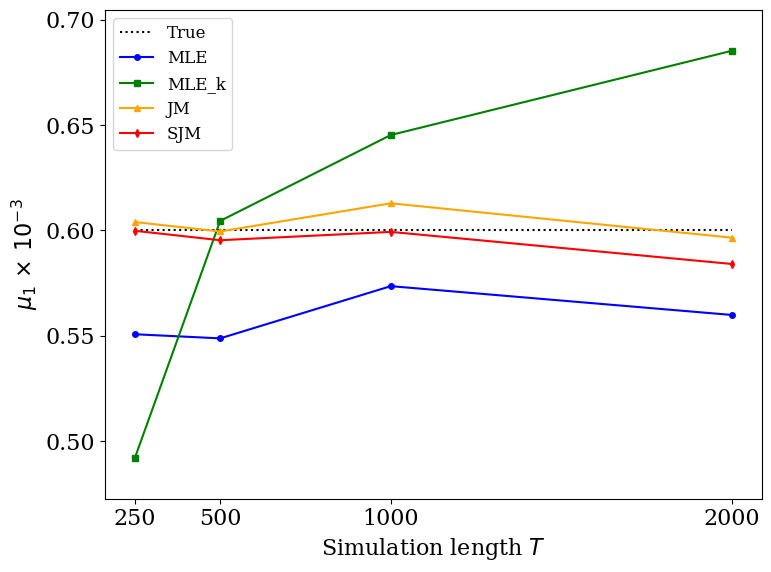

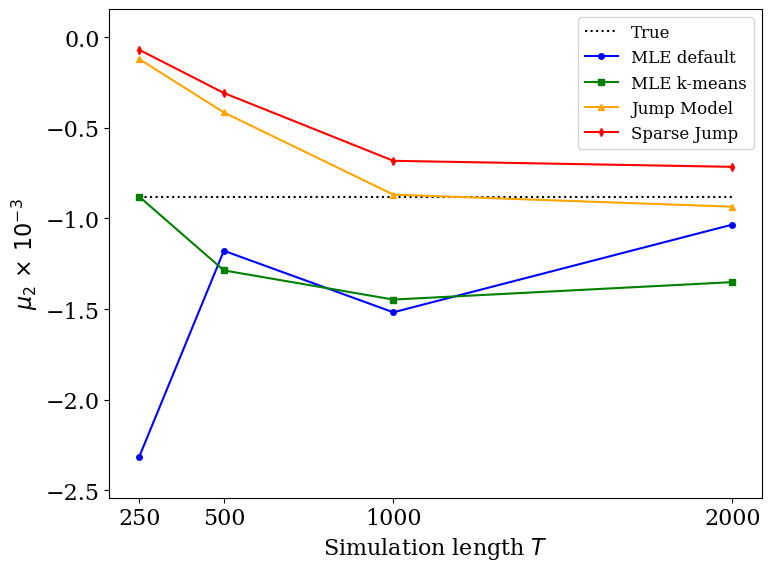

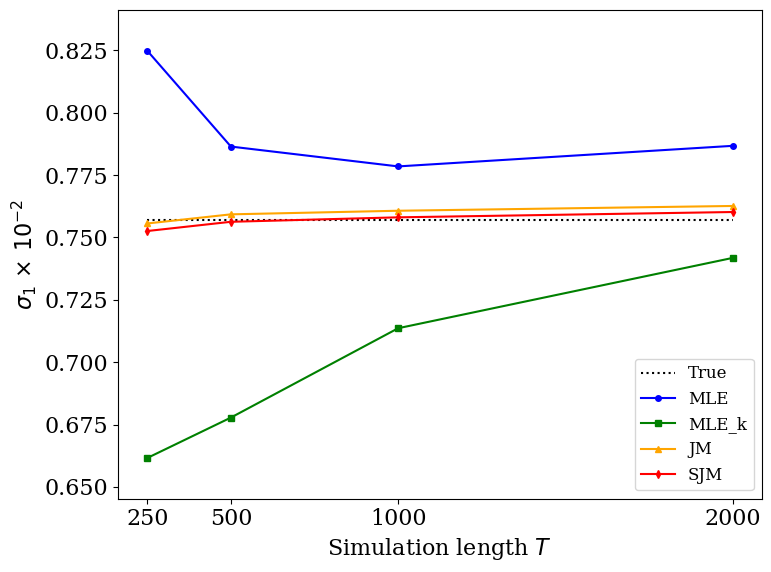

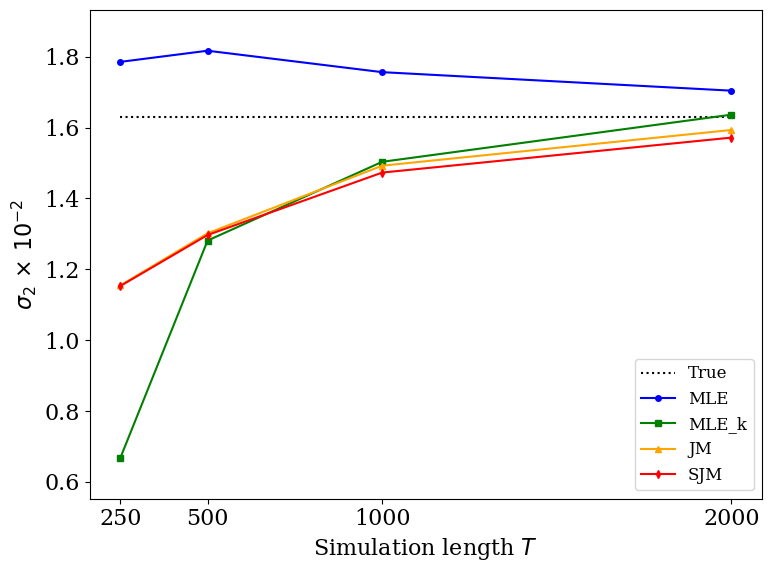

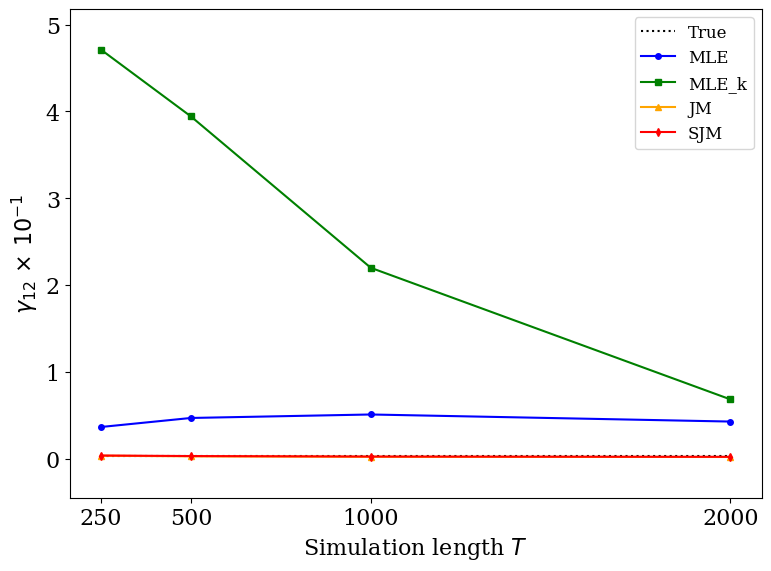

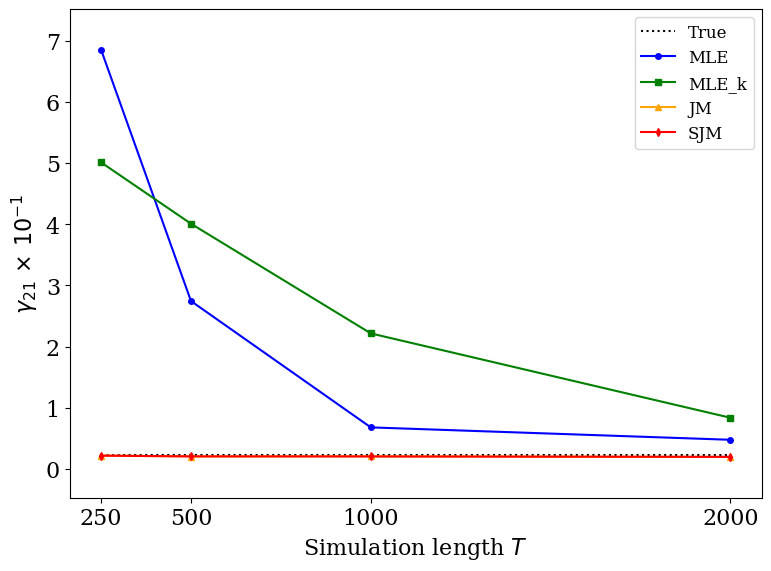

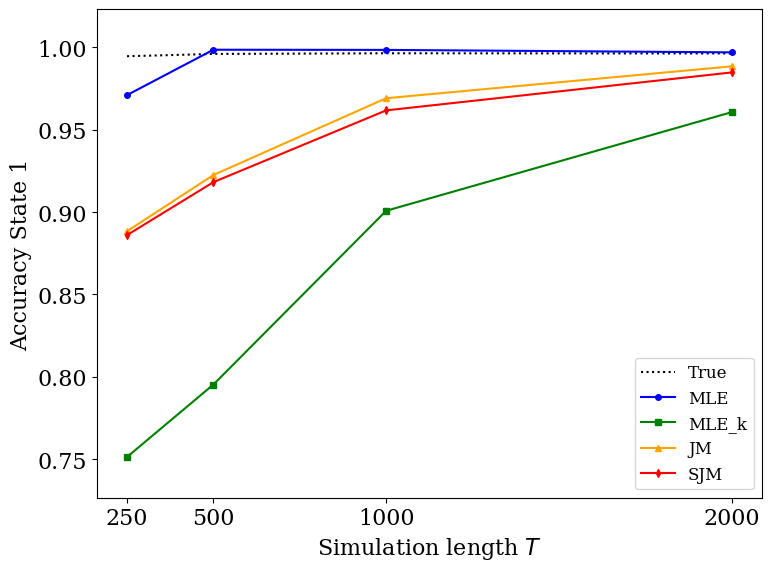

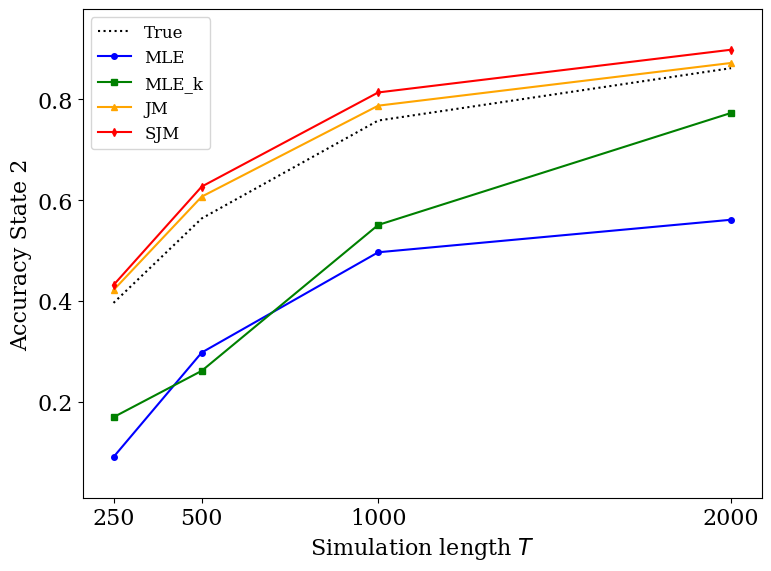

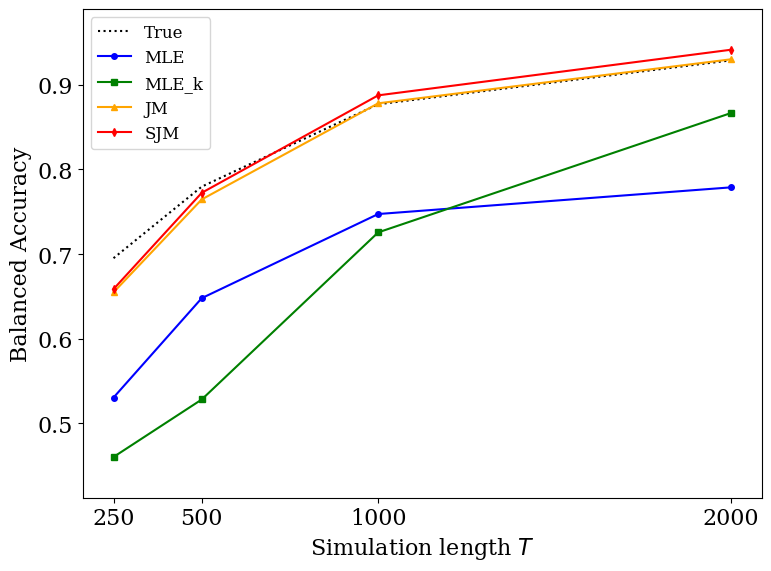

In [ ]:
custom_legend = {
    "True": "True",
    "MLE default": "MLE",
    "MLE k-means": "MLE_k",
    "Jump Model": "JM",
    "Sparse Jump": "SJM"
}

methods_to_plot = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]

plot_parameter(
    df=df_summary,
    param_col="state0_mean",
    param_label=r"$\mu_1$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e3,           
    preset_y_limits=None,       
    figsize=(8,6),
    legend_labels=custom_legend  
)

plot_parameter(
    df=df_summary,
    param_col="state1_mean",
    param_label=r"$\mu_2$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e3,
    preset_y_limits=None,
    figsize=(8,6)
)

plot_parameter(
    df=df_summary,
    param_col="state0_vol",
    param_label=r"$\sigma_1$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e2,           
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

plot_parameter(
    df=df_summary,
    param_col="state1_vol",
    param_label=r"$\sigma_2$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e2,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)


plot_parameter(
    df=df_summary,
    param_col="gamma12",
    param_label=r"$\gamma_{12}$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

plot_parameter(
    df=df_summary,
    param_col="gamma21",
    param_label=r"$\gamma_{21}$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

plot_parameter(
    df=df_summary,
    param_col="acc1",
    param_label=r"Accuracy State 1",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,            
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)


plot_parameter(
    df=df_summary,
    param_col="acc2",
    param_label=r"Accuracy State 2",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,            
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)


plot_parameter(
    df=df_summary,
    param_col="BAC",
    param_label=r"Balanced Accuracy",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,             
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

,state0_mean,state1_mean,state0_vol,state1_vol,gamma12,gamma21,acc1,acc2,BAC
True,0.000600,-0.000881,0.007570,0.016300,0.002400,0.023200,0.996200,0.861600,0.928900
MLE default,0.000560,-0.001034,0.007867,0.017043,0.042585,0.047648,0.996863,0.560851,0.778857
MLE k-means,0.000685,-0.001351,0.007418,0.016365,0.068103,0.083638,0.960590,0.772741,0.866666
Jump Model,0.000597,-0.000935,0.007626,0.015933,0.001756,0.019539,0.988369,0.871880,0.930124
Sparse Jump,0.000584,-0.000715,0.007602,0.015718,0.001954,0.019762,0.984683,0.898157,0.941420


#### Box Plots For performance

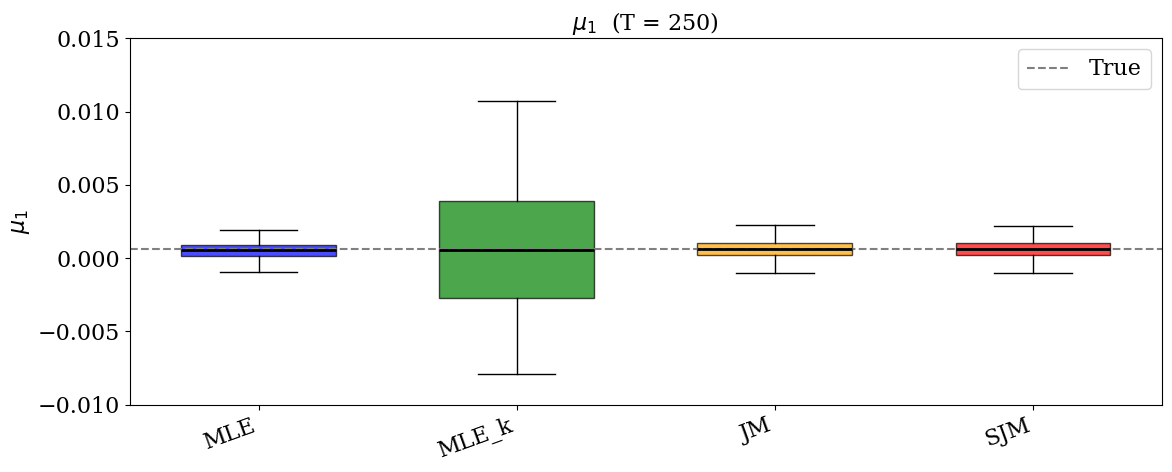

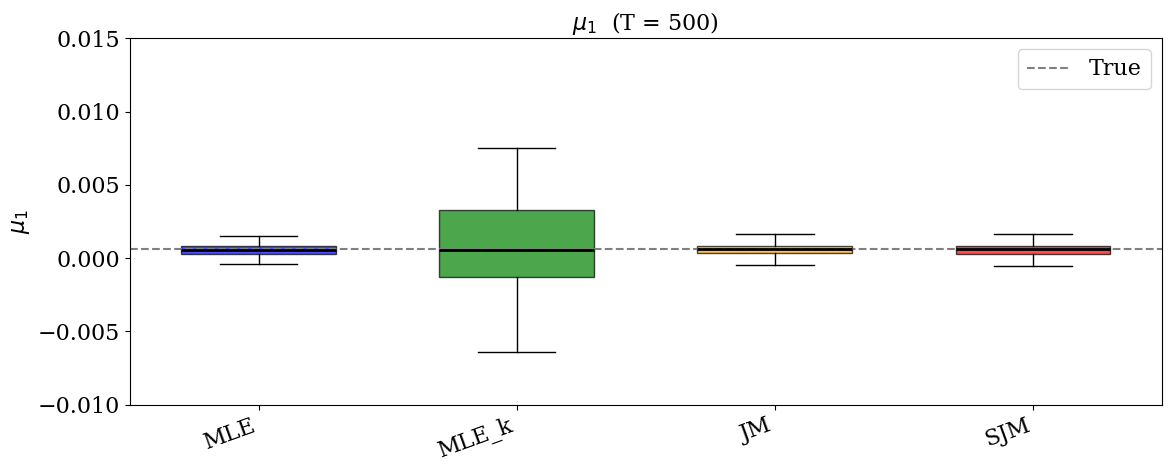

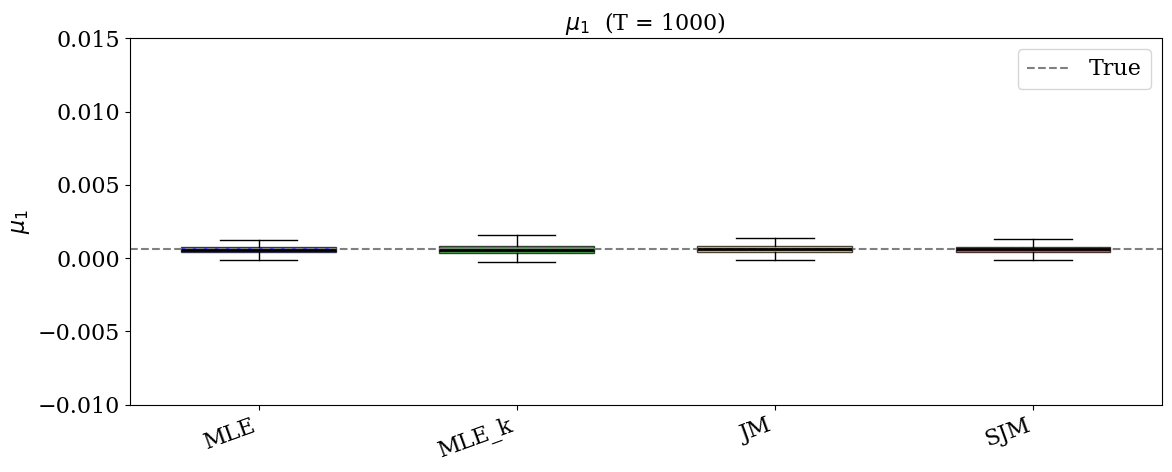

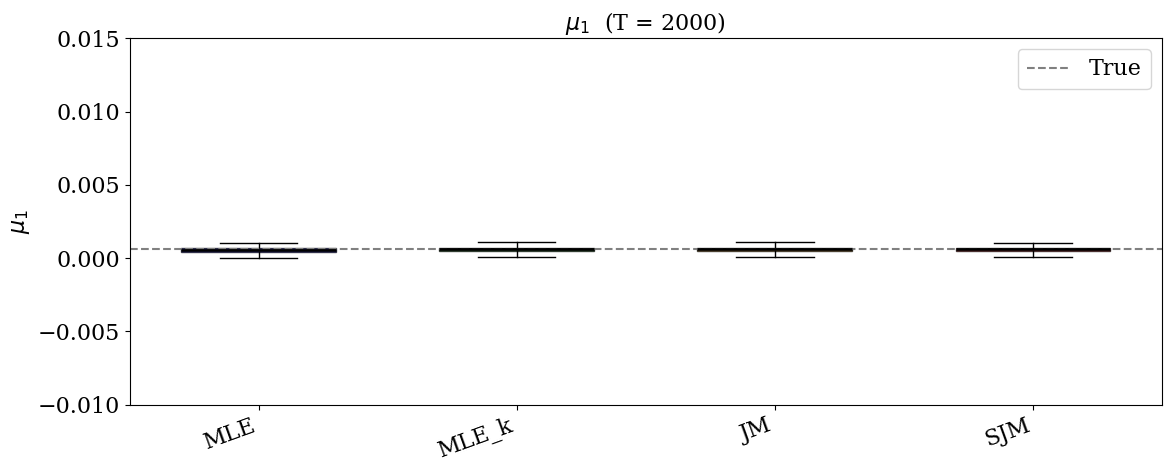

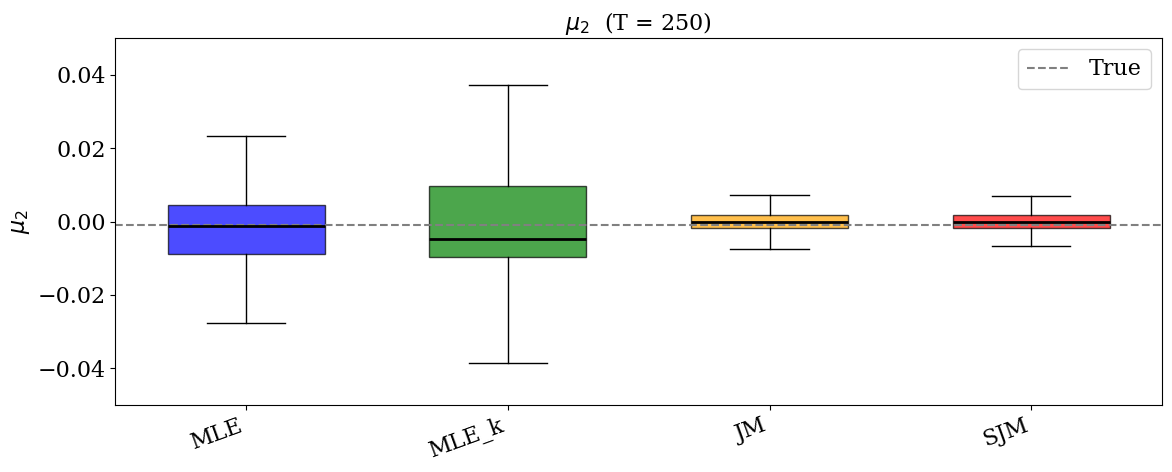

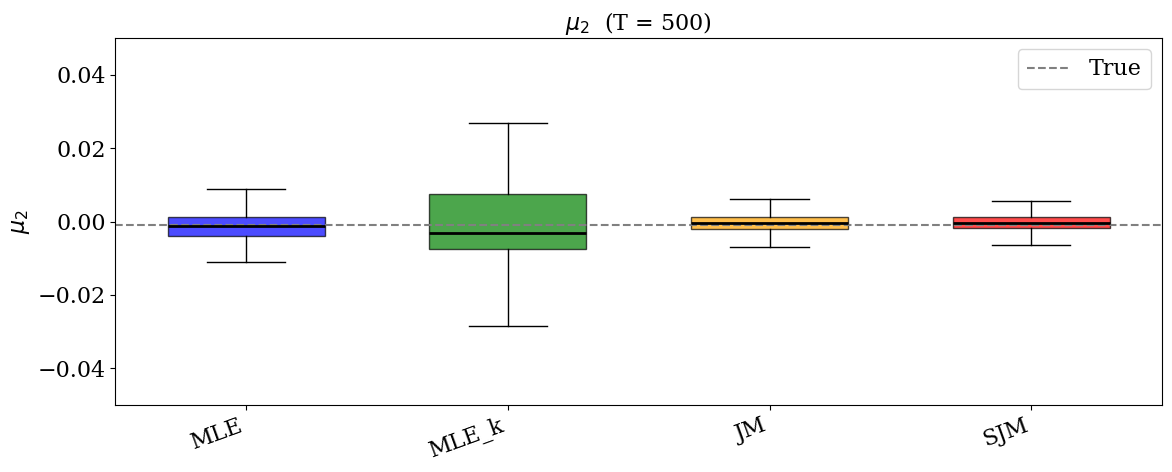

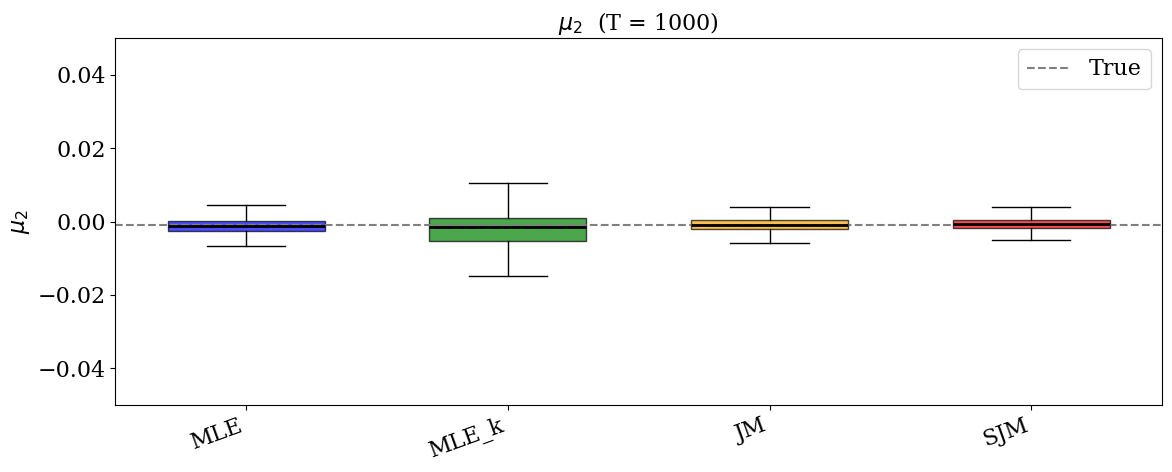

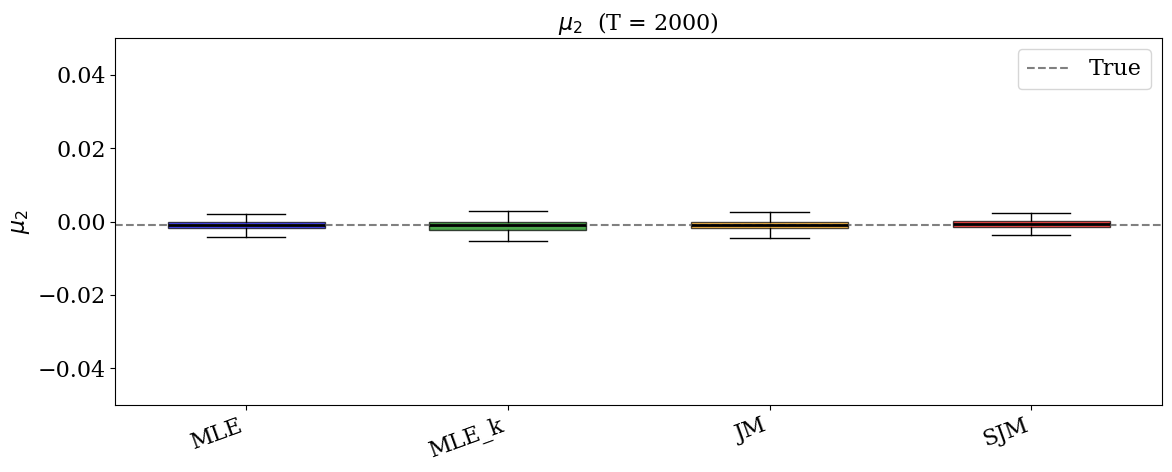

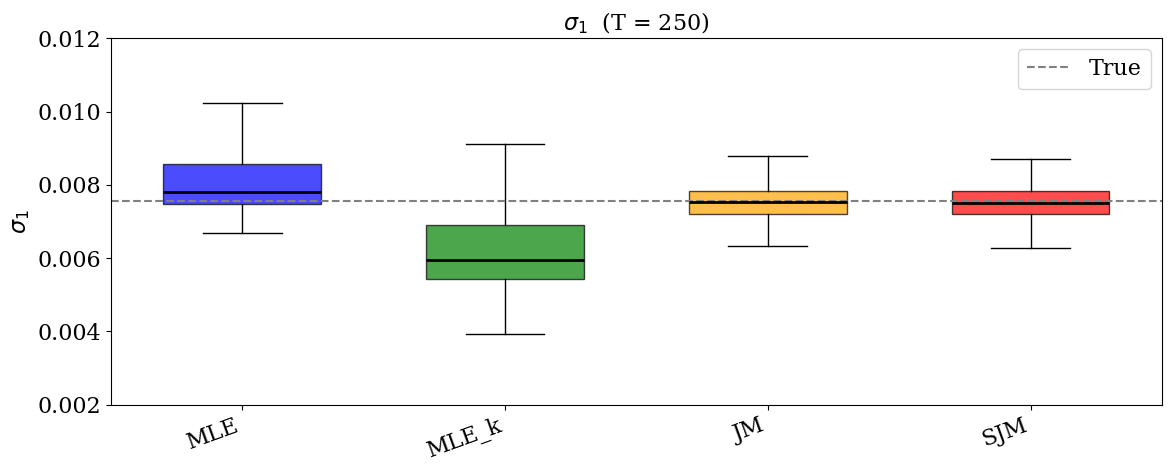

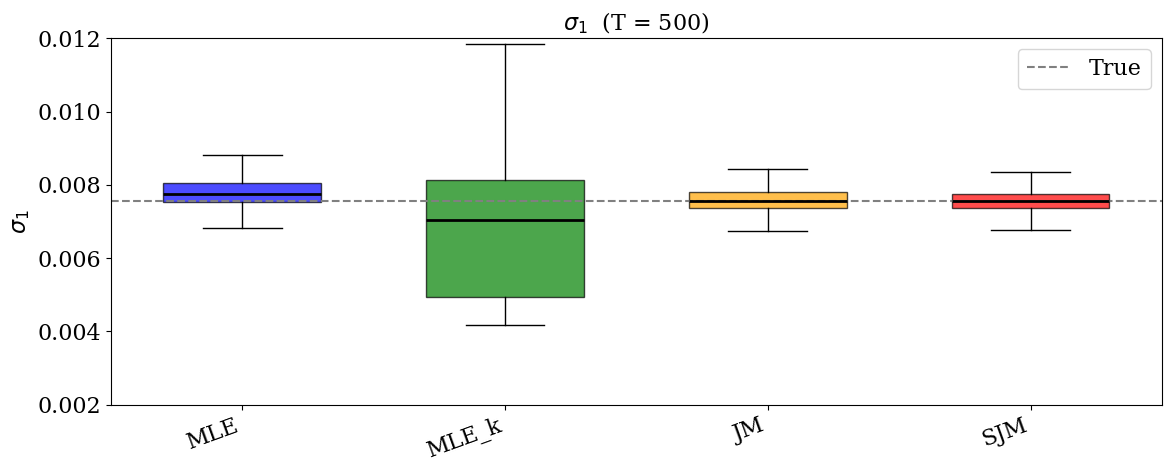

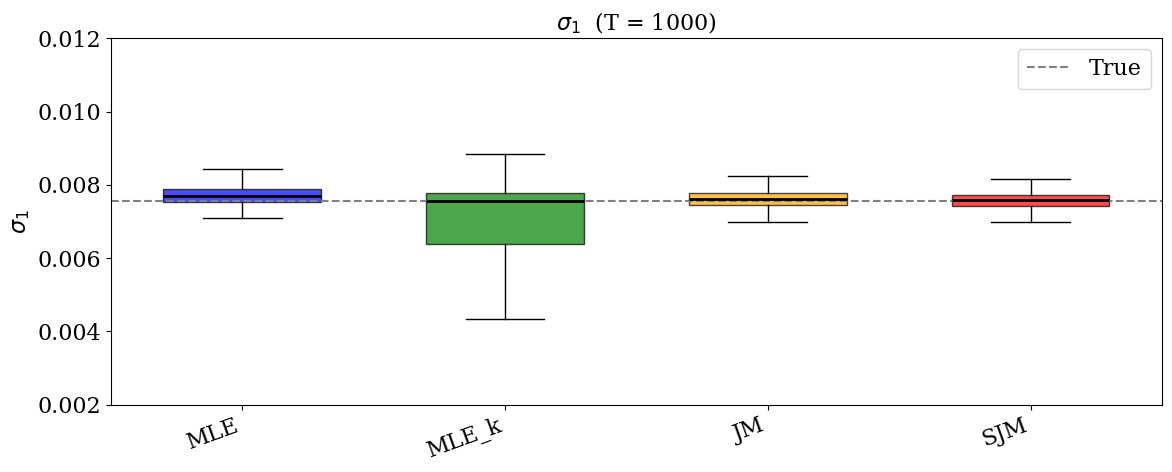

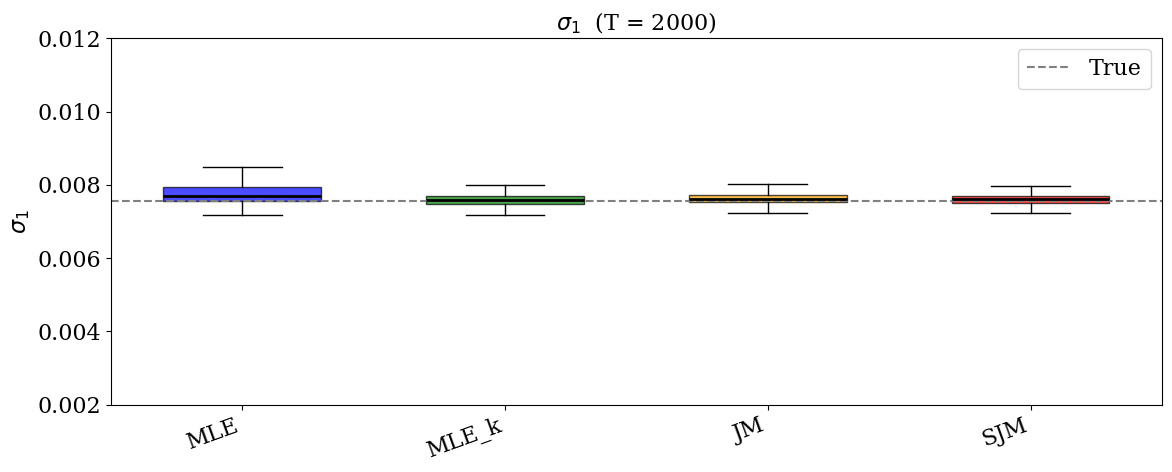

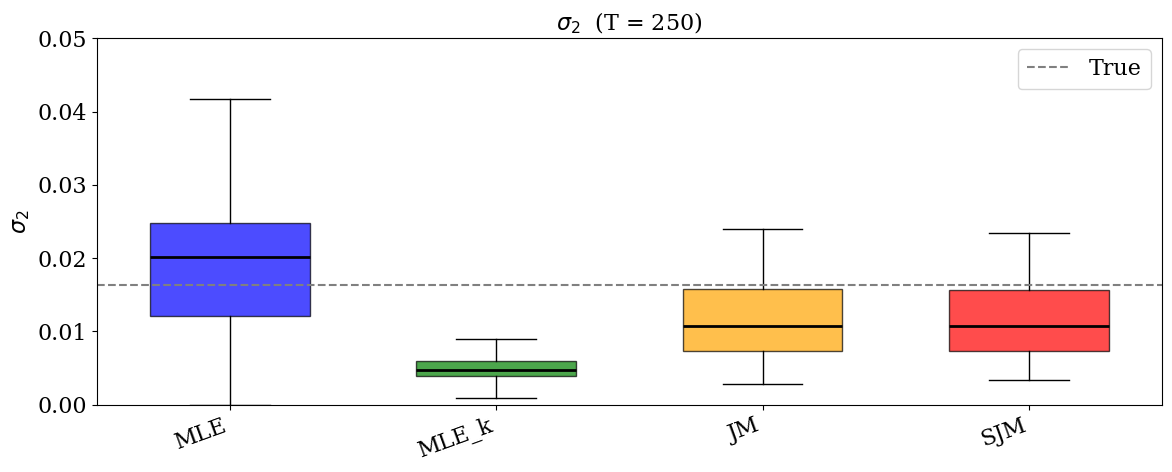

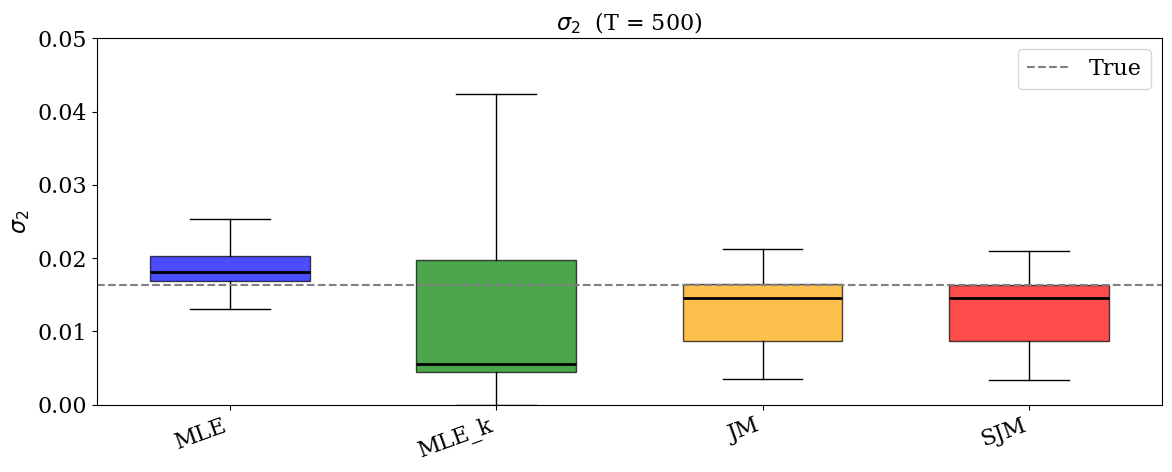

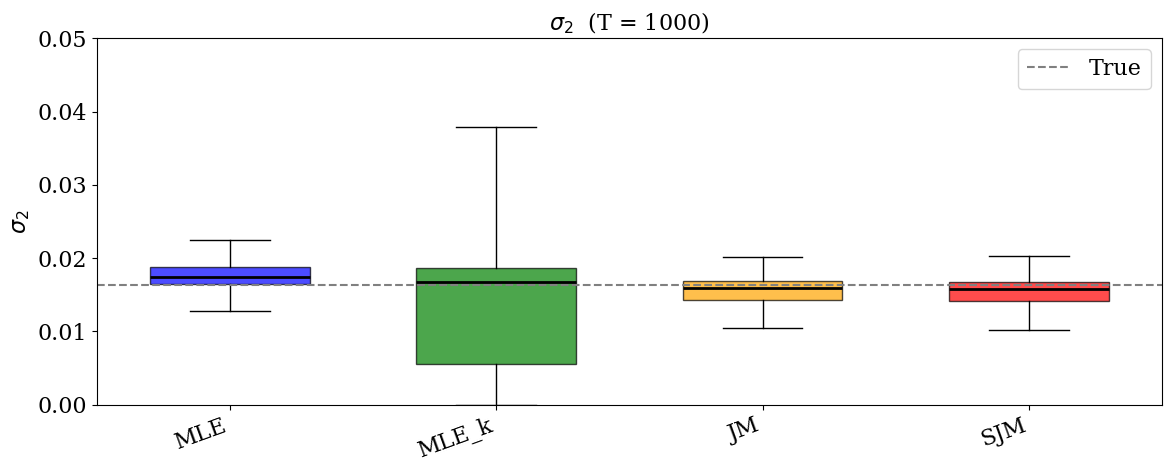

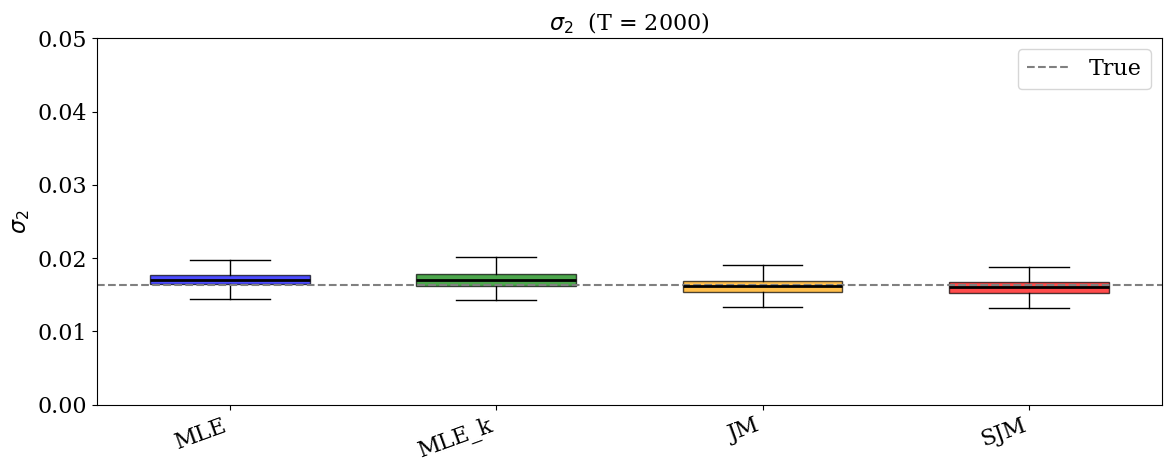

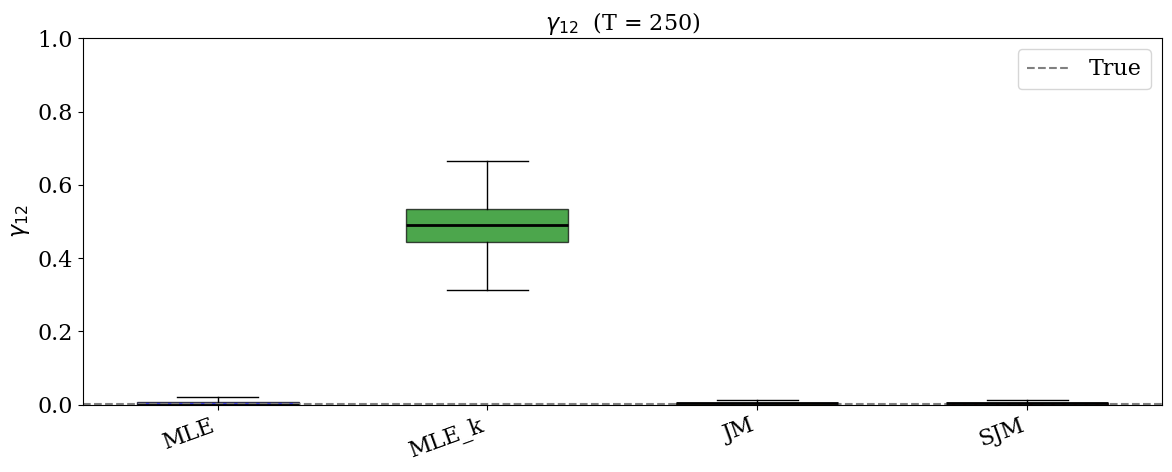

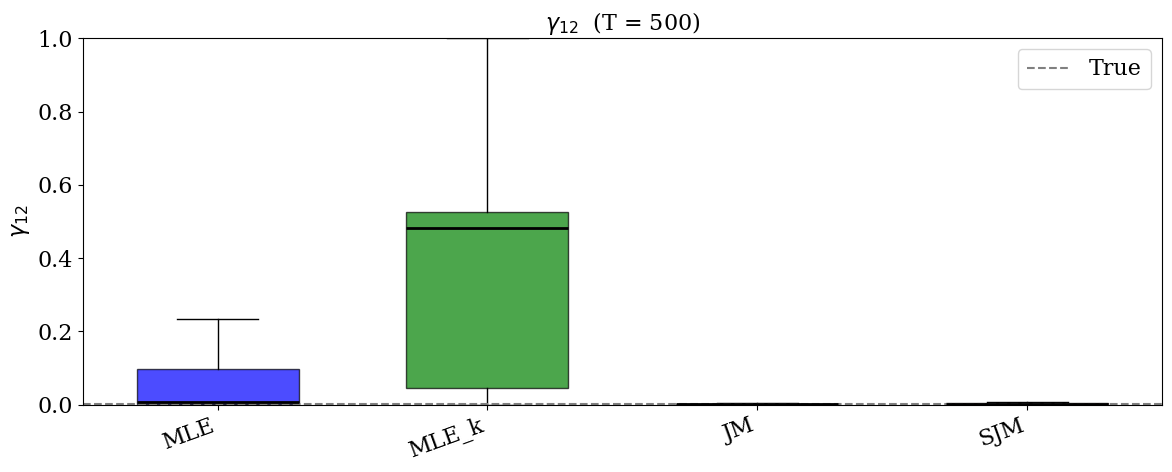

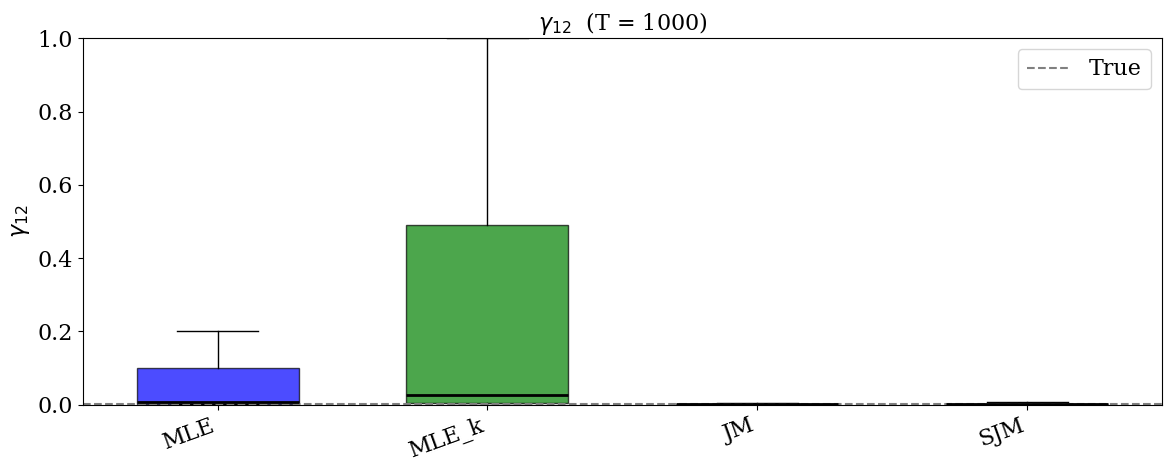

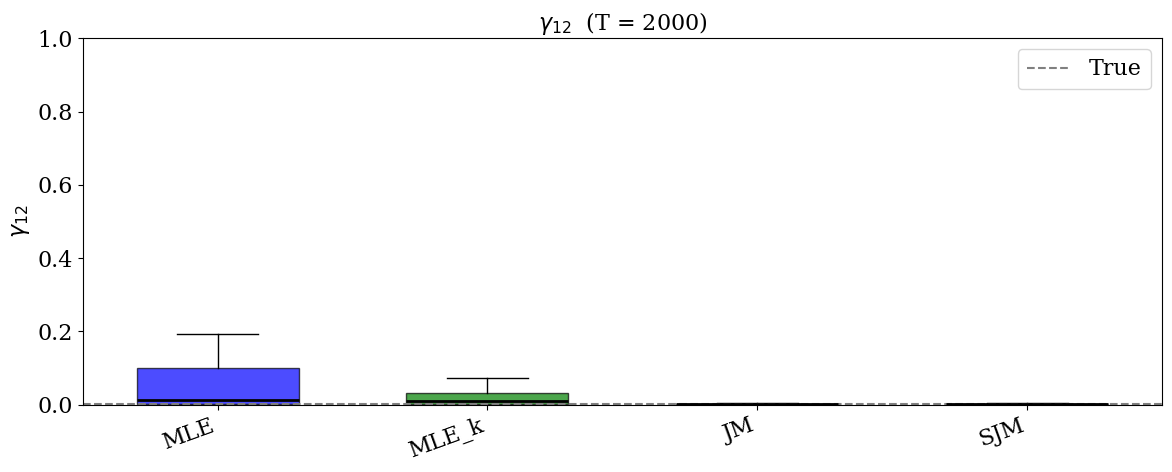

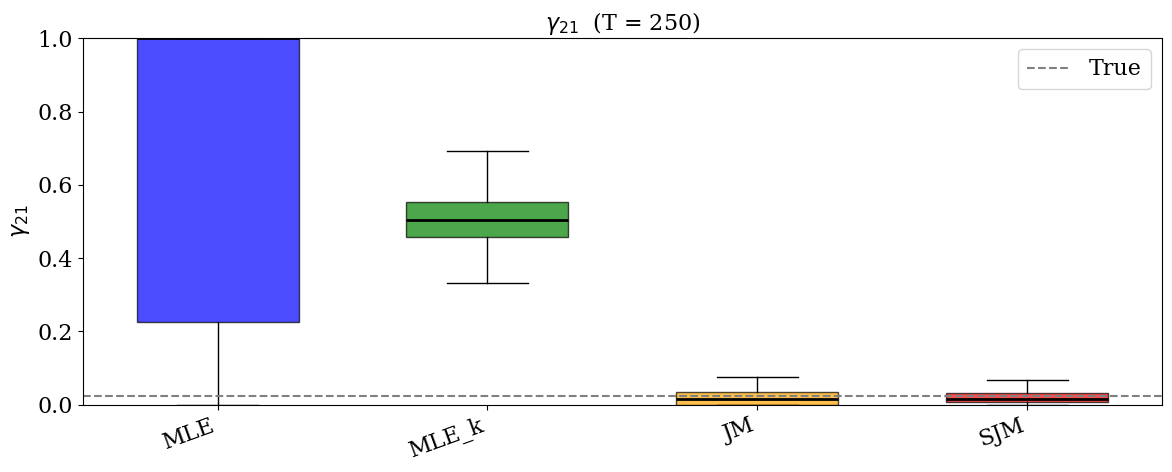

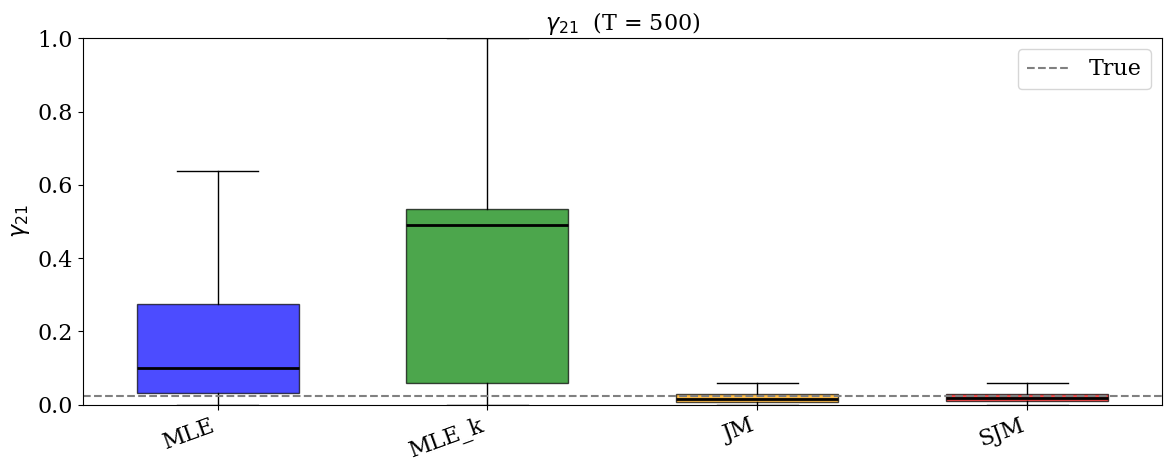

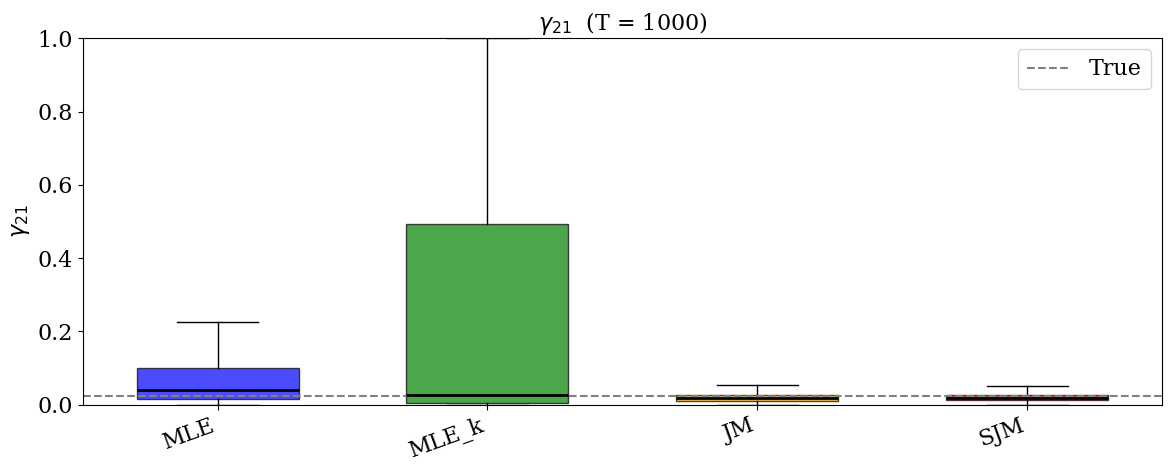

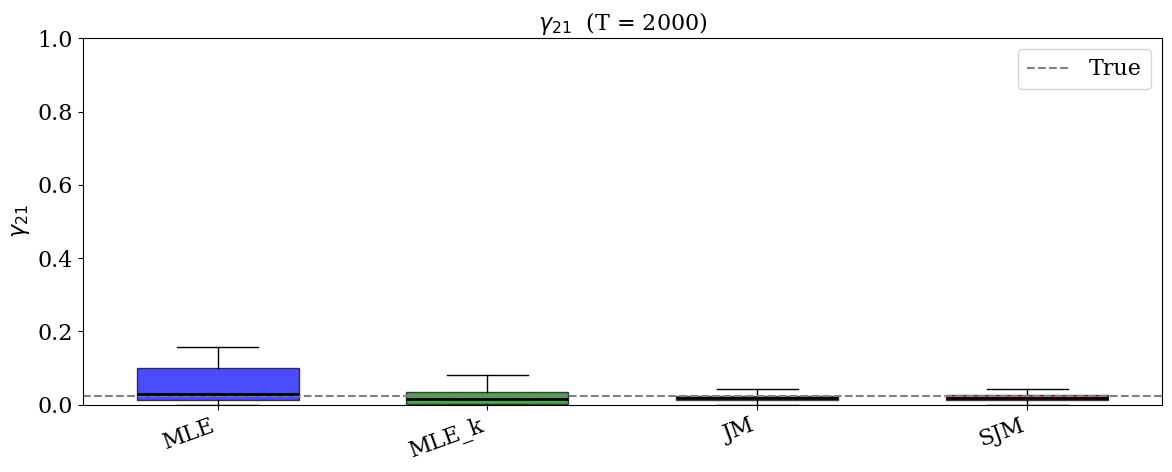

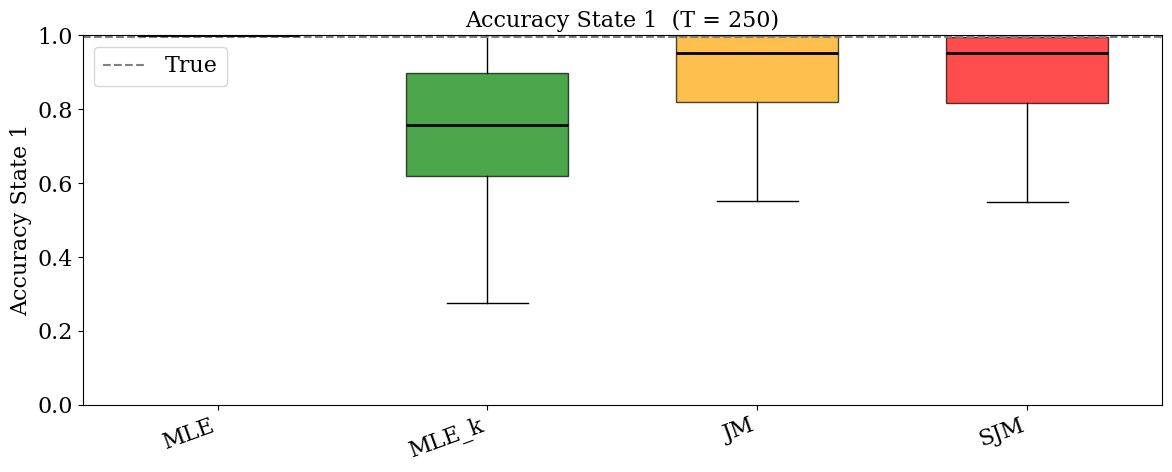

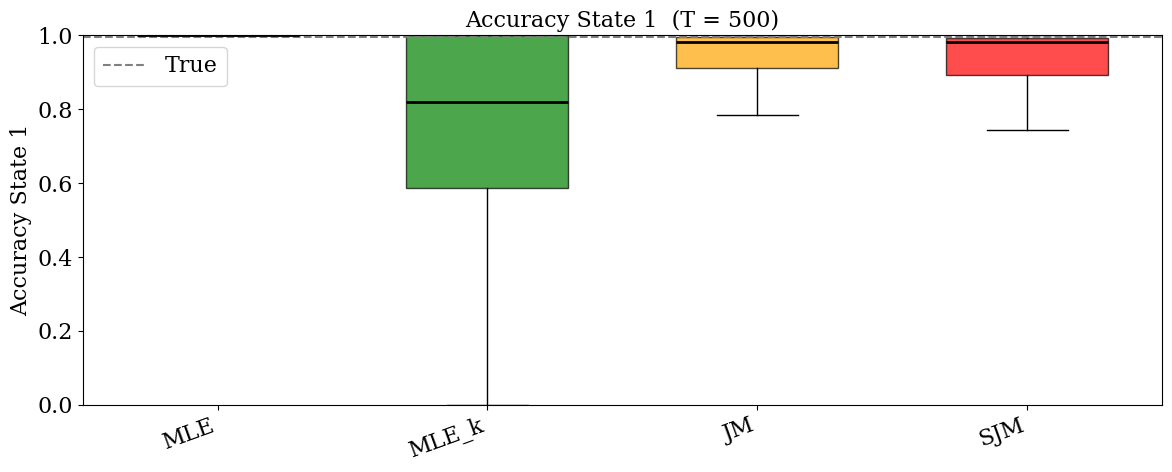

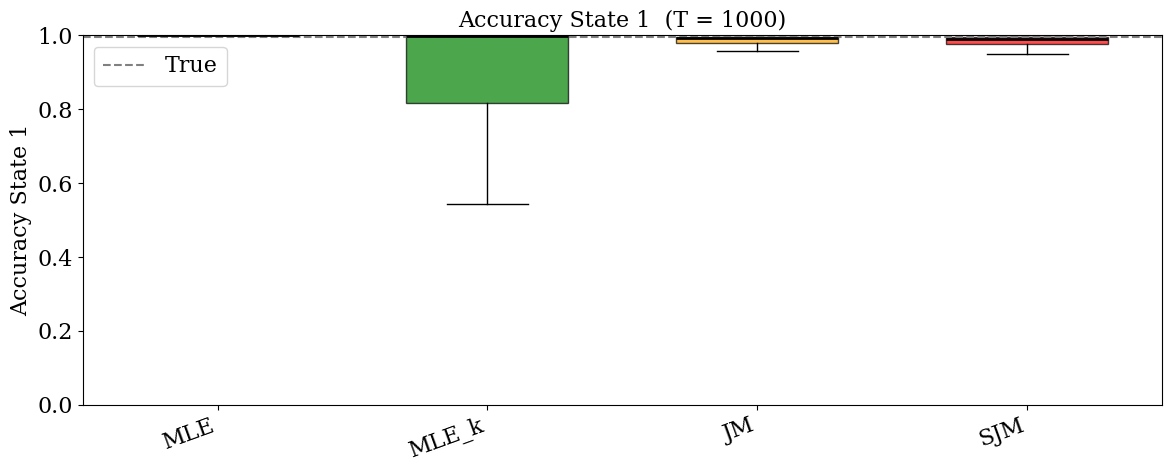

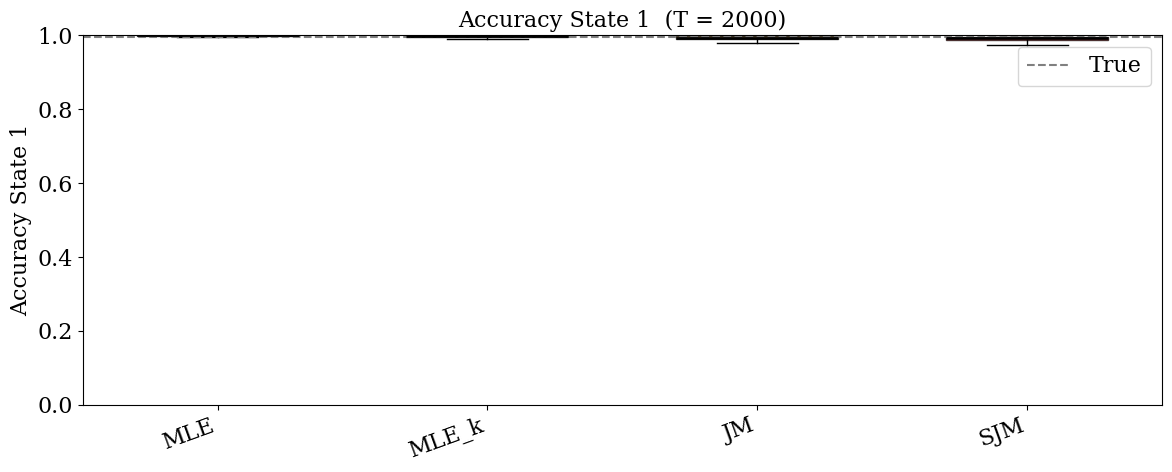

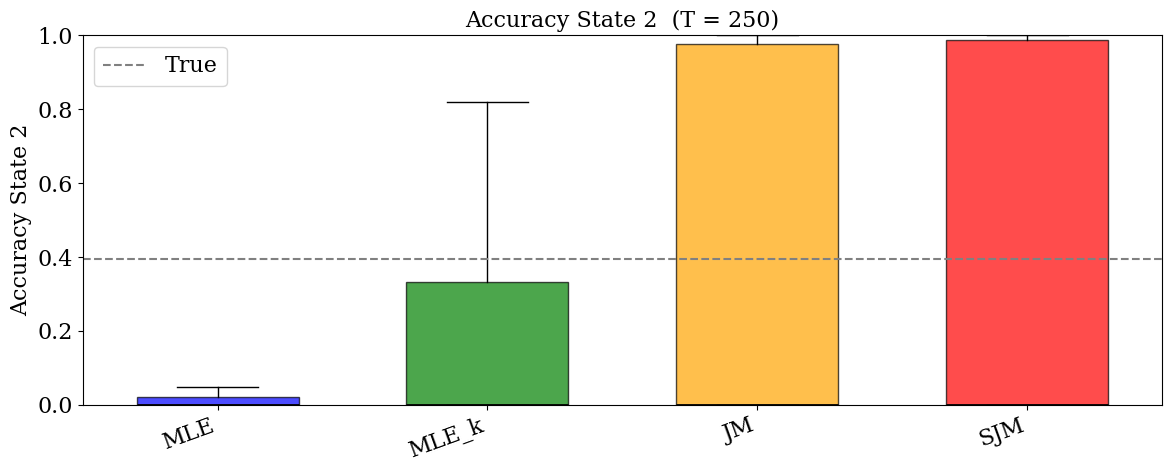

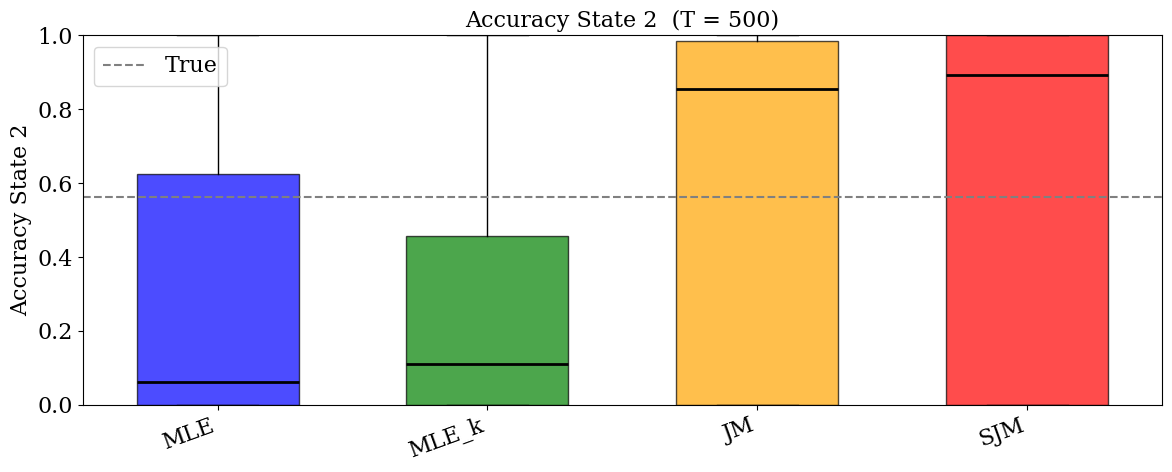

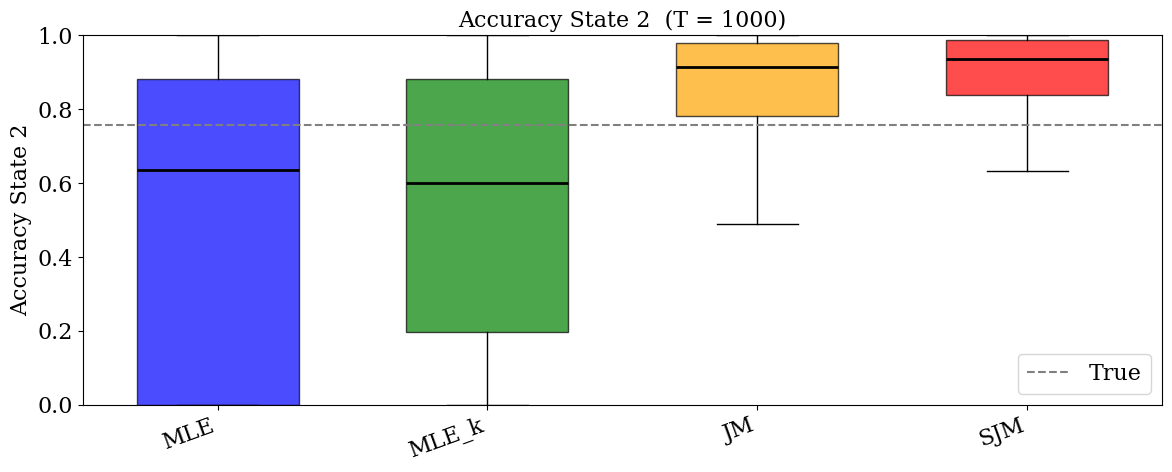

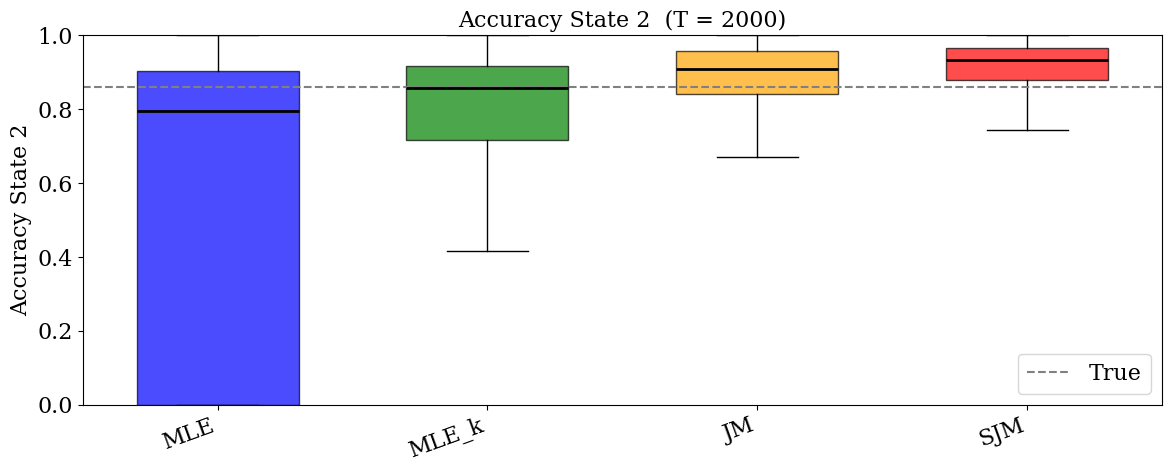

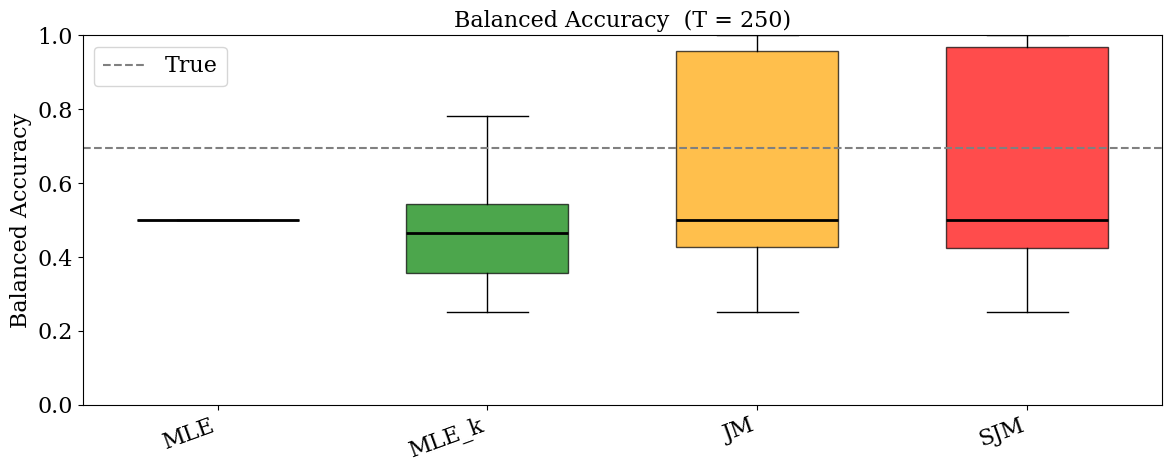

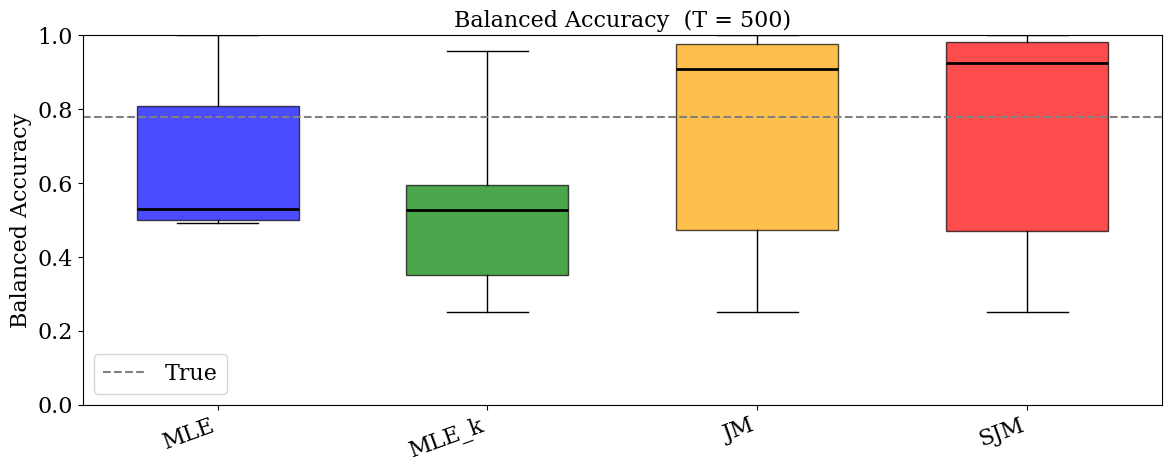

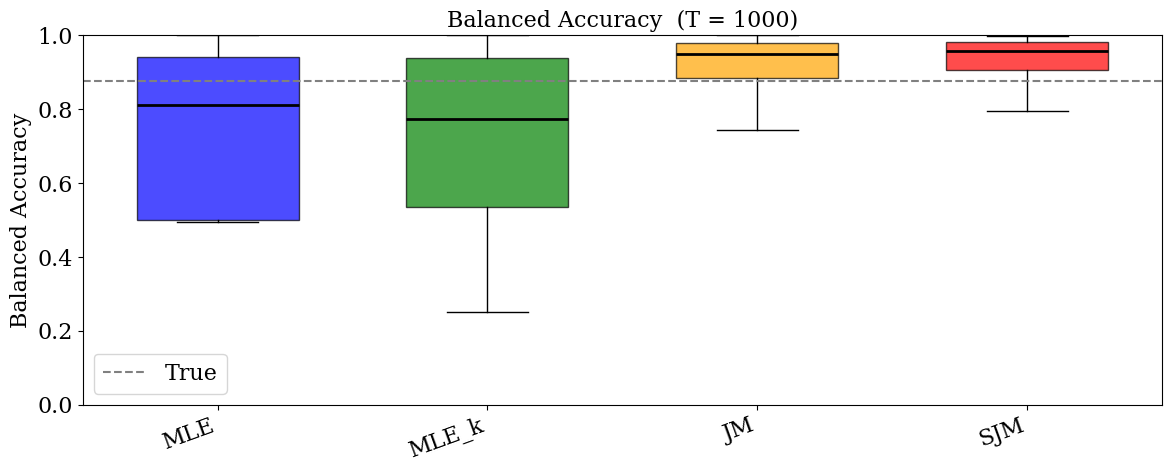

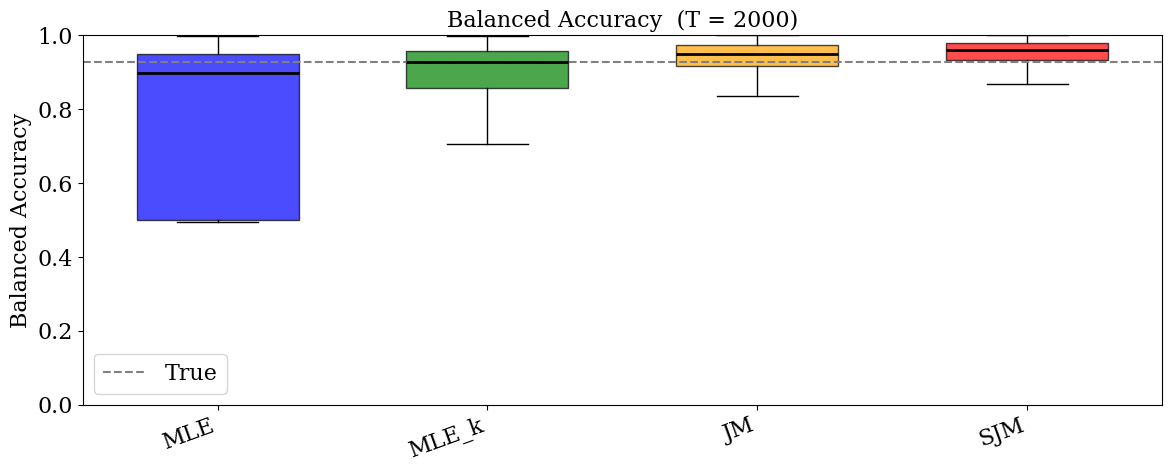

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

true_values = {
    250: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
        "acc1":        0.9945,
        "acc2":        0.3959,
        "BAC":         0.6952
    },
    500: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9959,
         "acc2":        0.5635,
         "BAC":         0.7797
    },
    1000: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9963,
         "acc2":        0.7577,
         "BAC":         0.8770
    },
    2000: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9962,
         "acc2":        0.8616,
         "BAC":         0.9289
    }
}

param_list = [
    "state0_mean", "state1_mean",
    "state0_vol",  "state1_vol",
    "gamma12",     "gamma21",
    "acc1",        "acc2",
    "BAC"
]
param_labels = {
    "state0_mean": r"$\mu_{1}$",
    "state1_mean": r"$\mu_{2}$",
    "state0_vol":  r"$\sigma_{1}$",
    "state1_vol":  r"$\sigma_{2}$",
    "gamma12":     r"$\gamma_{12}$",
    "gamma21":     r"$\gamma_{21}$",
    "acc1":        "Accuracy State 1",
    "acc2":        "Accuracy State 2",
    "BAC":         "Balanced Accuracy"
}

methods = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]
method_prefix = {
    "True": "True_",          
    "MLE default": "MLE_",
    "MLE k-means": "MLEK_",
    "Jump Model": "Jump_",
    "Sparse Jump": "SparseJump_"
}

T_values = [250, 500, 1000, 2000]


custom_y_limits = {
    "state0_mean": (-0.01, 0.015),
    "state1_mean": (-0.05, 0.05),
    "state0_vol":  (0.002, 0.012),
    "state1_vol":  (0., 0.05),
    "gamma12":     (0, 1),
    "gamma21":     (0, 1),
    "acc1":        (0, 1),
    "acc2":        (0, 1),
    "BAC":         (0, 1)
}


def plot_single_param_box(df, param, T_val, 
                          param_label="", 
                          y_limits=None, 
                          figsize=(10,5)):

    df_T = df[df["T"] == T_val]
    

    data_list = []
    method_labels = []
    for m in methods:
        if m == "True":
            continue  
        colname = method_prefix[m] + param
        values = df_T[colname].dropna().values
        data_list.append(values)
        method_labels.append(m)
    
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data_list, 
                     patch_artist=True, 
                     showfliers=False,
                     widths=0.6)
    
    box_colors = ["blue", "green", "orange", "red"]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(box_colors[i % len(box_colors)])
        box.set_alpha(0.7)
    for med in bp['medians']:
        med.set(color="black", linewidth=2.0)
    
    custom_labels = ["MLE", "MLE_k", "JM", "SJM"]  
    plt.xticks(np.arange(1, len(custom_labels)+1), custom_labels, rotation=20, ha="right")
    plt.title(f"{param_label}  (T = {T_val})")
    plt.ylabel(param_label)
    

    if T_val in true_values and param in true_values[T_val]:
        tv = true_values[T_val][param]
        plt.axhline(tv, color="gray", linestyle="--", linewidth=1.5, label="True")
        plt.legend(loc="best")
    
    if y_limits is not None:
        plt.ylim(y_limits)
    
    plt.tight_layout()
    plt.show()


for param in param_list:
    all_vals = []
    for T_val in T_values:
        if T_val in true_values and param in true_values[T_val]:
            all_vals.append(true_values[T_val][param])
        for m in methods:
            if m == "True":
                continue
            colname = method_prefix[m] + param
            all_vals.extend(final_results[final_results["T"] == T_val][colname].dropna().values)
    
    if len(all_vals) == 0:
        continue
    
    if param in custom_y_limits:
        y_limits = custom_y_limits[param]
    else:
        dmin, dmax = min(all_vals), max(all_vals)
        margin = 0.05 * (dmax - dmin) if (dmax > dmin) else 1e-6
        y_limits = (dmin - margin, dmax + margin)
    
    for T_val in T_values:
        plot_single_param_box(
            df=final_results,
            param=param,
            T_val=T_val,
            param_label=param_labels.get(param, param),
            y_limits=y_limits,
            figsize=(12,5)
        )

In [ ]:
final_result_errors = pd.read_csv("g_final_result_errors.csv")
df = pd.read_csv("g_final_result_errors.csv")

metrics = ["state0_mean", "state1_mean", "state0_vol", "state1_vol",
           "gamma12", "gamma21", "acc1", "acc2", "BAC"]
methods = ["MLE", "MLEK", "Jump", "SparseJump"]

for metric in metrics:
    true_col = f"True_{metric}"
    for method in methods:
        est_col = f"{method}_{metric}"
        mse_col = f"{method}_{metric}_MSE"
        df[mse_col] = (df[est_col] - df[true_col]) ** 2

mse_tables = {}
for T_val in sorted(df["T"].unique()):
    df_T = df[df["T"] == T_val]
    mse_data = {}
    for method in methods:
        method_data = {}
        for metric in metrics:
            mse_col = f"{method}_{metric}_MSE"
            method_data[metric] = df_T[mse_col].mean()
        mse_data[method] = method_data
    mse_table = pd.DataFrame(mse_data).T  
    mse_tables[T_val] = mse_table
    print(f"--- MSE Table for T = {T_val} ---")
    print(mse_table.round(6), "\n")



--- MSE Table for T = 250 ---
            state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
MLE            0.000008     0.000387    0.000004    0.000127  0.018140  0.601764  0.028711  0.146691  0.034342
MLEK           0.000026     0.000208    0.000006    0.000146  0.246192  0.254612  0.093054  0.108034  0.069783
Jump           0.000000     0.000009    0.000000    0.000044  0.000009  0.000490  0.031353  0.215522  0.072622
SparseJump     0.000000     0.000008    0.000000    0.000043  0.000011  0.000441  0.032068  0.222706  0.075043 

--- MSE Table for T = 500 ---
            state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
MLE            0.000000     0.000134    0.000000    0.000048  0.013647  0.197558  0.001016  0.201895  0.049916
MLEK           0.000013     0.000173    0.000005    0.000147  0.225240  0.212114  0.081462  0.177648  0.099550
Jump           0.000000     0.000008    0.000000  